In [1]:
%load_ext autoreload
%autoreload 2

# 1. Create dataset
Use Sam to extract proposals from input images (100 images) then for proposals with same regions as the ground truth masks, they are considered as positive sameple to the templates ( use the BlenderProc 42 templates), negative otherwise

Run through 100 images - then return positive proposals and negative proposals

Use IoU >0.5 to get the postive proposals

## 1.1 Extract positive proposals (the same ones as gt mask)

In [2]:
from src.model.constrastive_learning import extract_dataset_train_pbr

dataset = "hudiebanjin"
data_type = "train_pbr"
scene_id = 0
pos_proposals, neg_proposals, best_mask_indices = extract_dataset_train_pbr(dataset, data_type, scene_id) # Take 2.21 minutes

[2024-09-26 10:07:33,822] [INFO] src.model.constrastive_learning: loading sam
[2024-09-26 10:07:33,823] [INFO] root: Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything
[2024-09-26 10:07:38,204] [INFO] root: Init CustomSamAutomaticMaskGenerator done!
  0%|          | 0/250 [00:00<?, ?it/s][2024-09-26 10:07:57,082] [INFO] src.model.constrastive_learning: Keeping only 35 from 57 masks
[2024-09-26 10:07:59,341] [INFO] src.model.constrastive_learning: Number of prediction masks: 35, positive proposals: 8, negative proposals: 27
  0%|          | 1/250 [00:19<1:19:22, 19.13s/it][2024-09-26 10:08:10,354] [INFO] src.model.constrastive_learning: Keeping only 52 from 83 masks
[2024-09-26 10:08:13,711] [INFO] src.model.constrastive_learning: Number of prediction masks: 52, positive proposals: 16, negative proposals: 36
  1%|          | 2/250 [00:33<1:07:29, 16.33s/it][2024-09-26 10:08:32,082] [INFO] src.model.constrastive_learning: Keeping only 51 from 72 masks
[2024-09-26

In [3]:
# len(neg_proposals)


In [4]:
all_pos_proposals = [item for sublist in pos_proposals for item in sublist]
all_neg_proposals = [item for sublist in neg_proposals for item in sublist]

In [5]:
len(all_neg_proposals)

7113

In [6]:
len(all_pos_proposals)

4712

In [7]:
import pickle
#train_pbr_pos_proposals_sam_inside_0 is without noise
# train_pbr_pos_proposals_sam_inside_100_pre is with noise but positve  only when pred inside gt smaller than 100 
# train_pbr_neg_proposals_sam_inside_100_pre_filter is train_pbr_neg_proposals_sam_inside_100_pre with remove small bboxes and masks
# train_pbr_pos_proposals_sam_inside_100_pre_filter_neg is train_pbr_neg_proposals_sam_inside_100_pre_filter but negative pairs from not pred_is_inside_indices ( so more negative crops)
# test_pos_proposals_sam_inside_100_pre_filter_neg for test dataset

with open('contrastive_learning/outputs/train_pbr_pos_hudiebanjin.pkl', 'wb') as file:
    pickle.dump(all_pos_proposals, file)

with open('contrastive_learning/outputs/train_pbr_neg_hudiebanjin.pkl', 'wb') as file:
    pickle.dump(all_neg_proposals, file)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pickle

# train_pbr_neg_proposals_sam_inside_100_pre_filter is the best one to choose

with open('contrastive_learning/outputs/train_pbr_pos_hudiebanjin.pkl', 'rb') as file:
    pos = pickle.load(file)

with open('contrastive_learning/outputs/train_pbr_neg_hudiebanjin.pkl', 'rb') as file:
    neg = pickle.load(file)

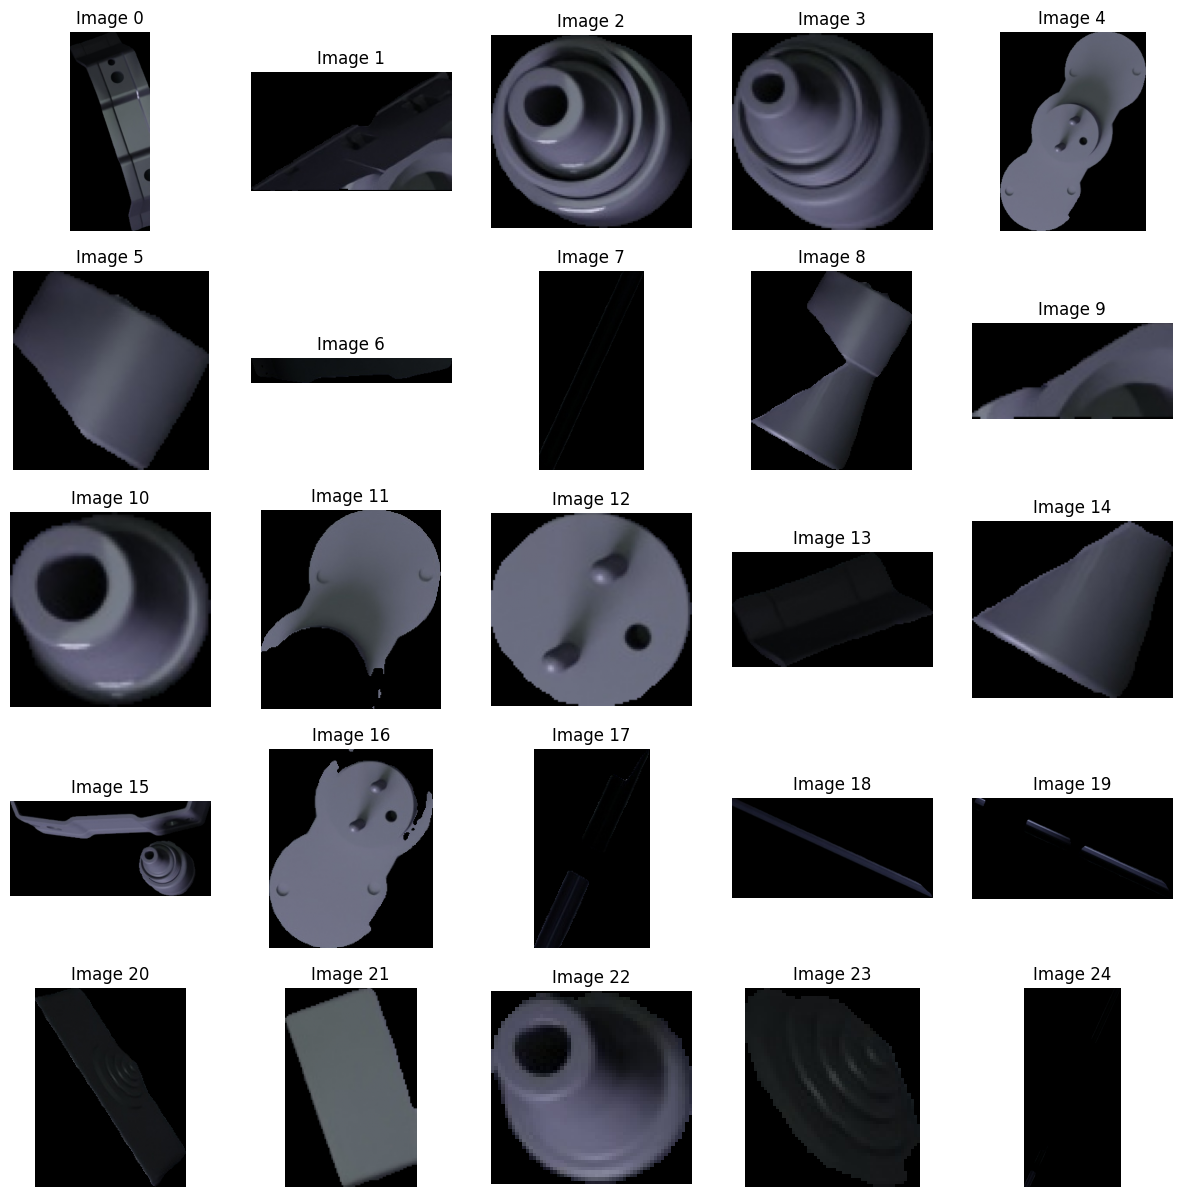

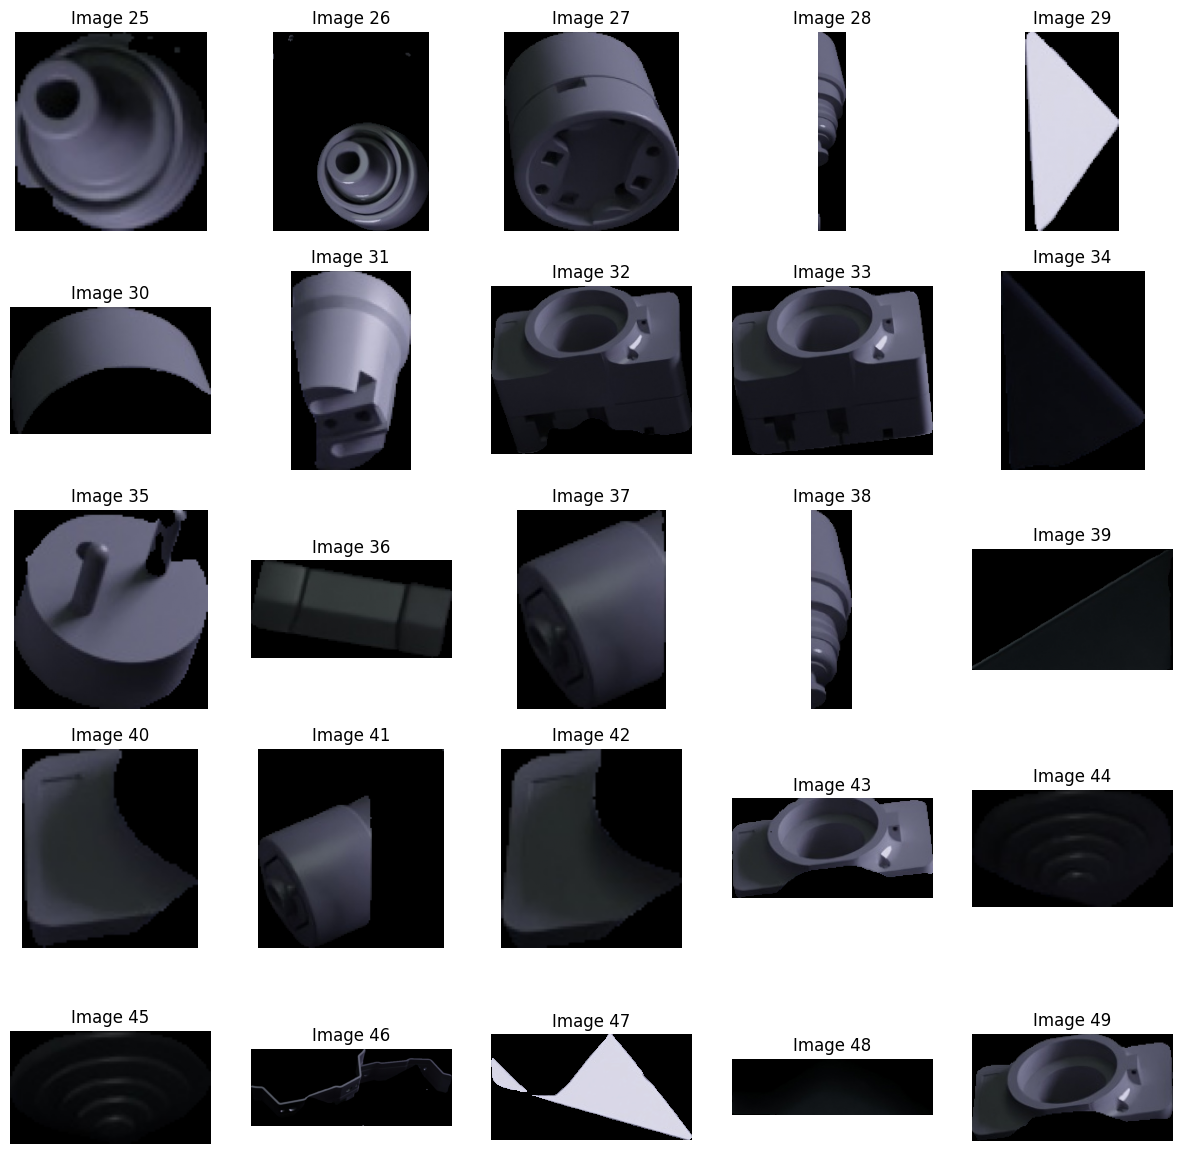

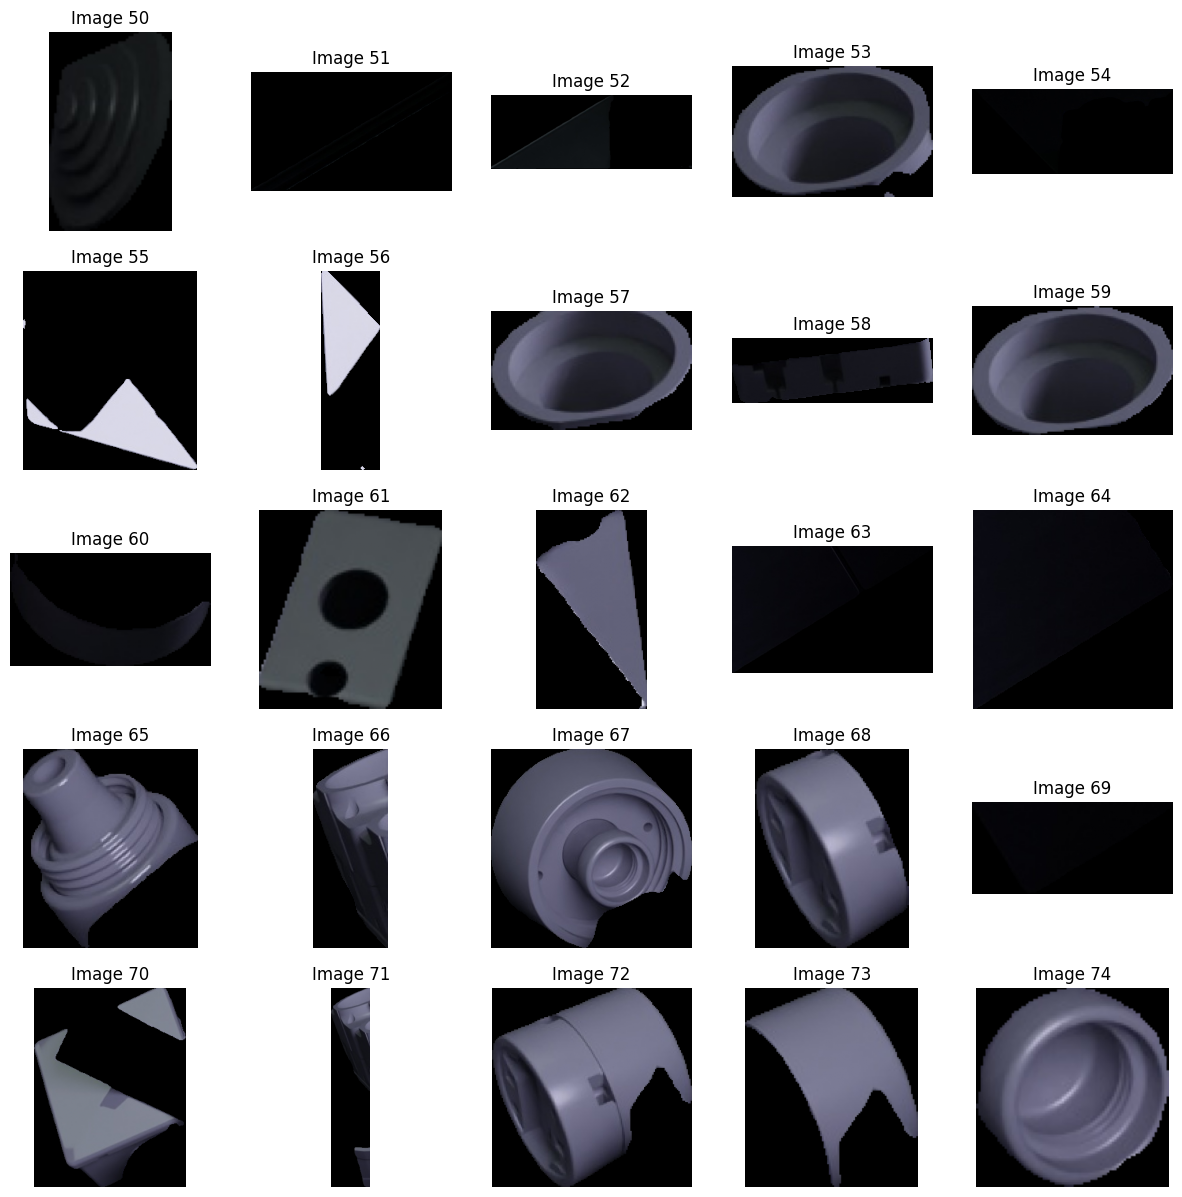

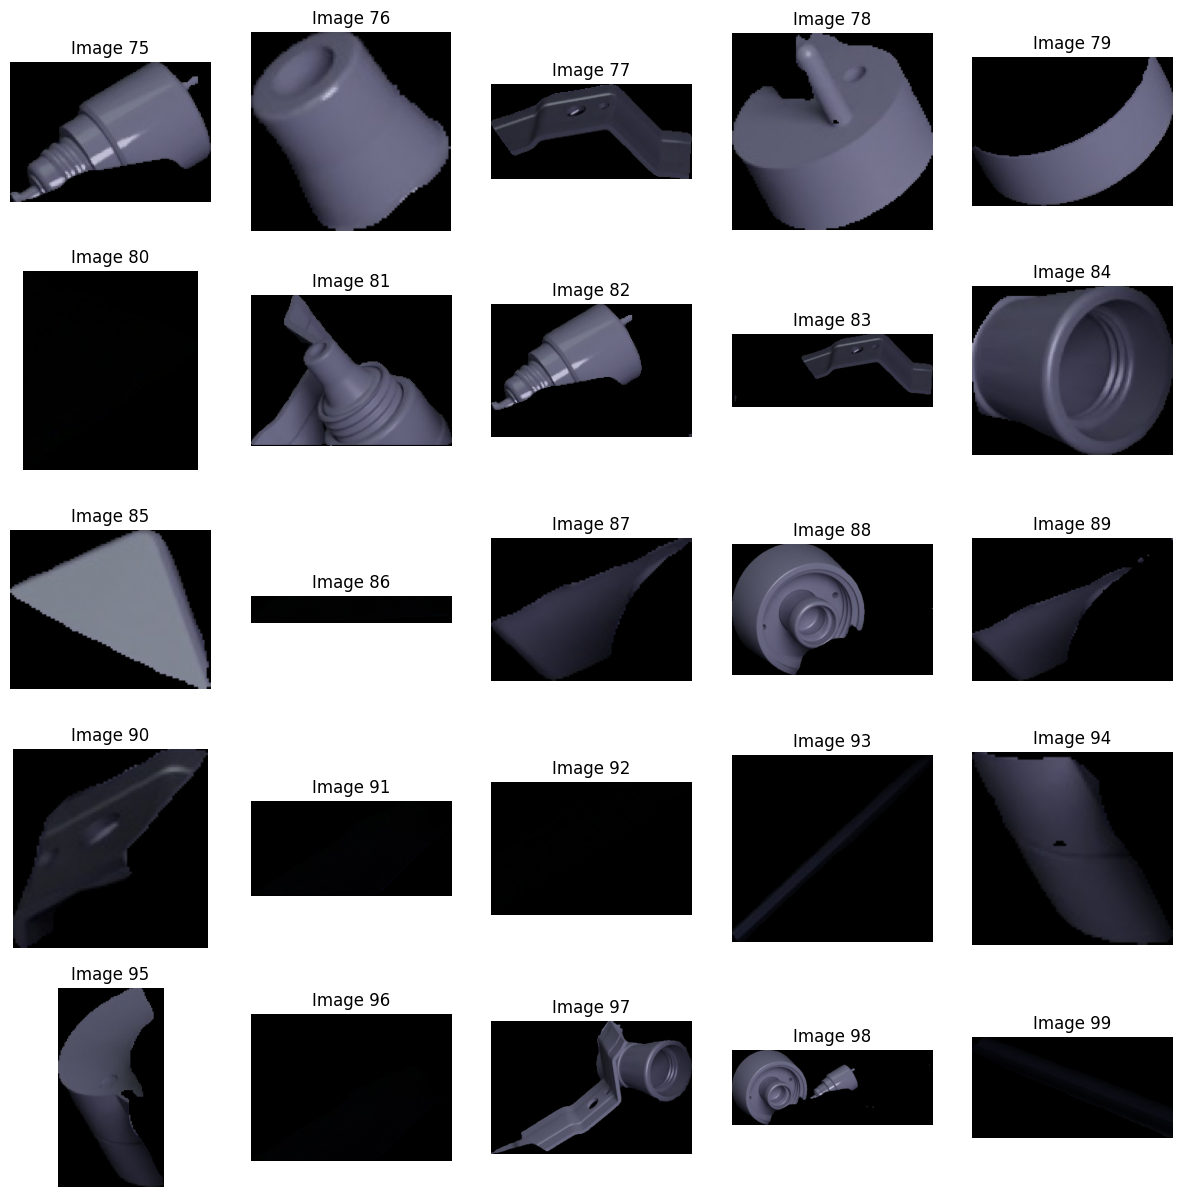

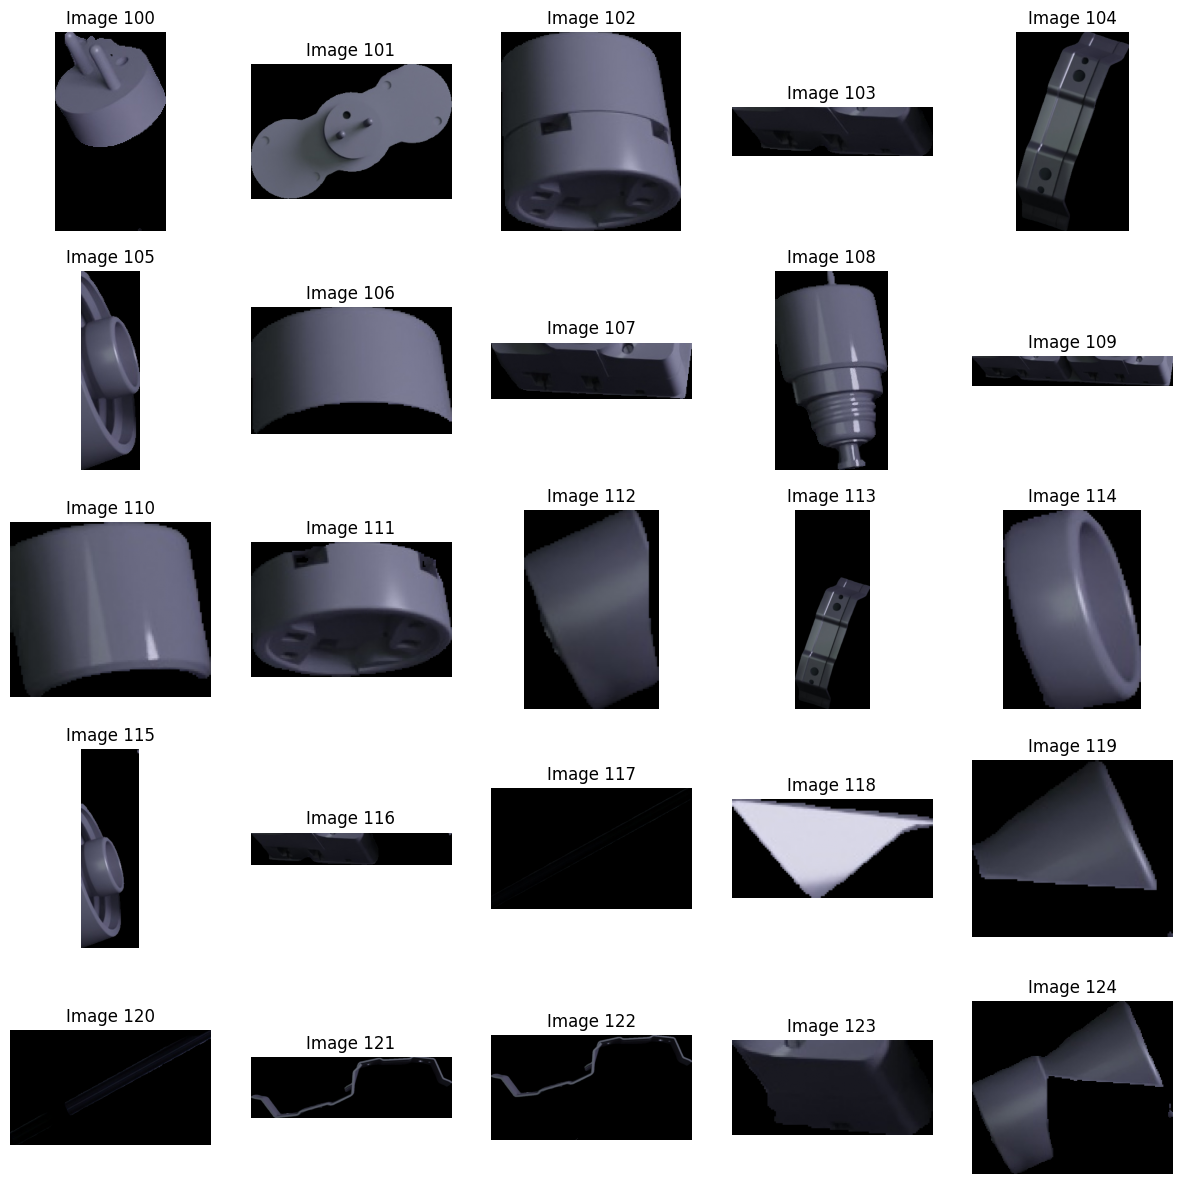

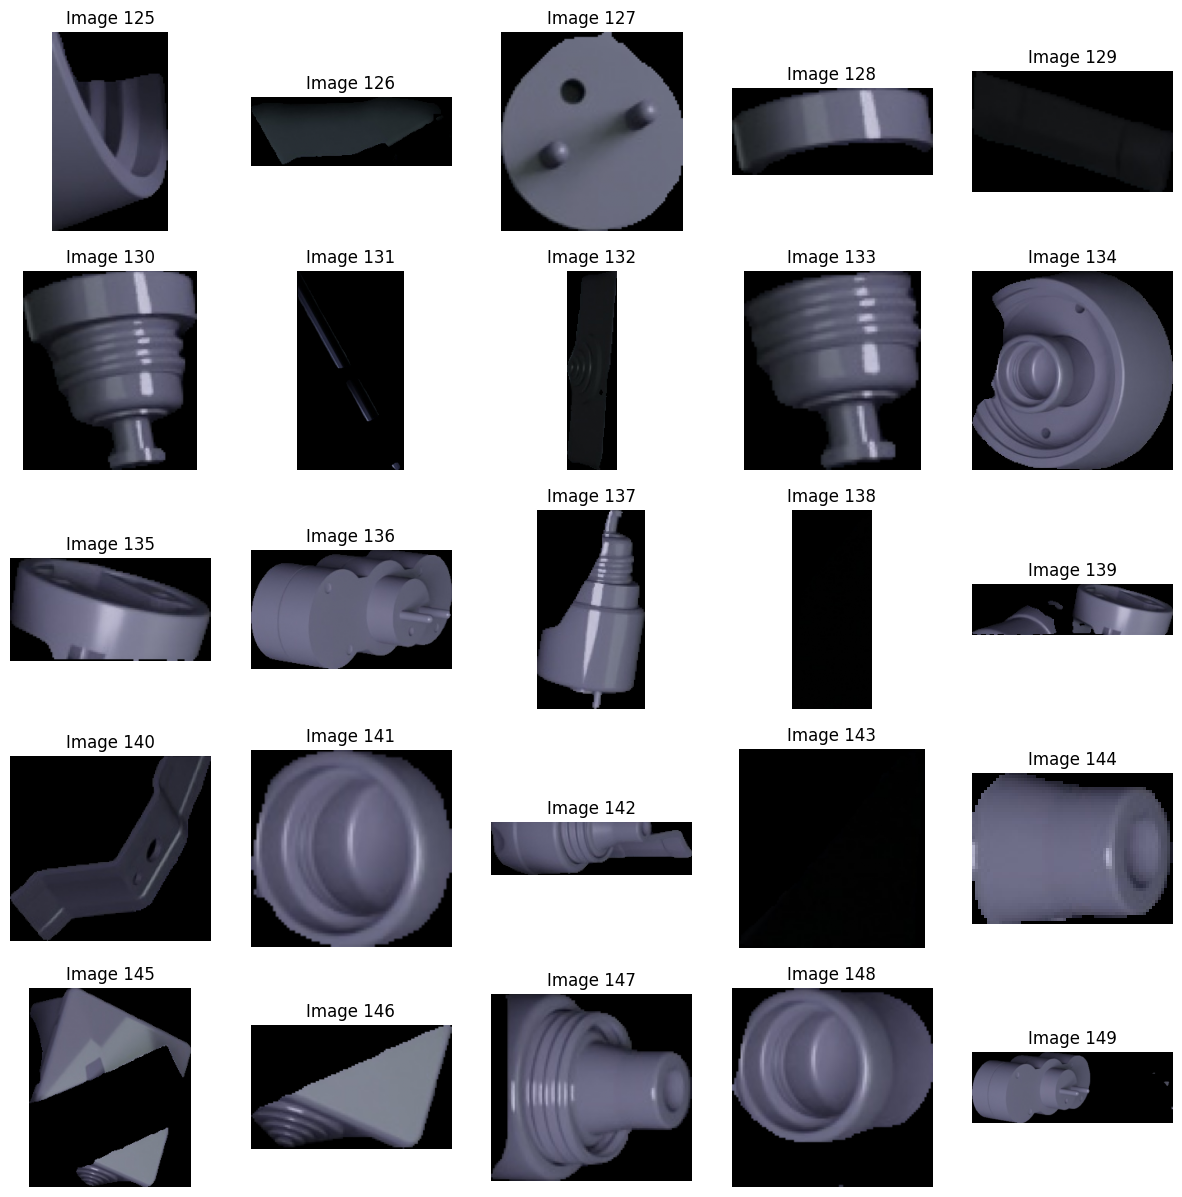

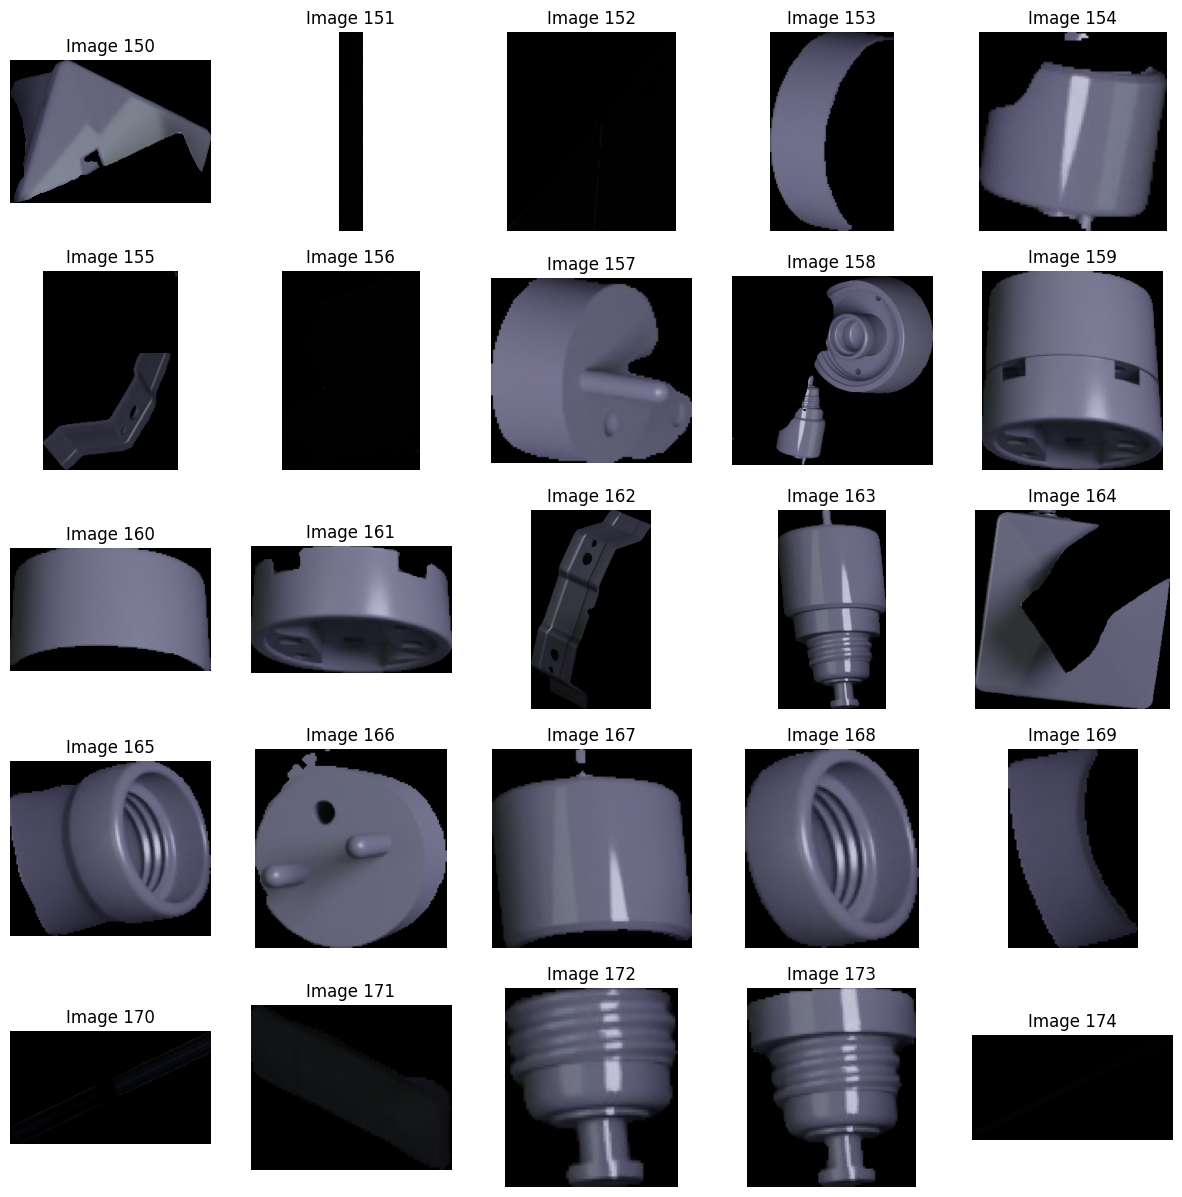

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display at a time
images_per_page = 25

# Define the number of rows and columns for the grid
rows = 5
cols = 5

# Iterate over the images in steps of images_per_page
for i in range(0, 160, images_per_page):
    # Create a new figure for each set of 25 images
    plt.figure(figsize=(15, 15))

    for j in range(images_per_page):
        # Calculate the current image index
        image_index = i + j

        # Check if the image_index is within the bounds of the list
        if image_index >= len(neg):
            break

        # Add a subplot for the current image
        plt.subplot(rows, cols, j + 1)
        plt.imshow(np.array(neg[image_index]))
        plt.title(f"Image {image_index}")
        plt.axis('off')

    # Display the figure containing 25 images
    plt.show()


In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of images to display at a time
# images_per_page = 25

# # Define the number of rows and columns for the grid
# rows = 5
# cols = 5

# # Iterate over the images in steps of images_per_page
# for i in range(0, 160, images_per_page):
#     # Create a new figure for each set of 25 images
#     plt.figure(figsize=(15, 15))

#     for j in range(images_per_page):
#         # Calculate the current image index
#         image_index = i + j

#         # Check if the image_index is within the bounds of the list
#         if image_index >= len(neg):
#             break

#         # Add a subplot for the current image
#         plt.subplot(rows, cols, j + 1)
#         plt.imshow(np.array(neg[image_index]))
#         plt.title(f"Image {image_index}")
#         plt.axis('off')

#     # Display the figure containing 25 images
#     plt.show()


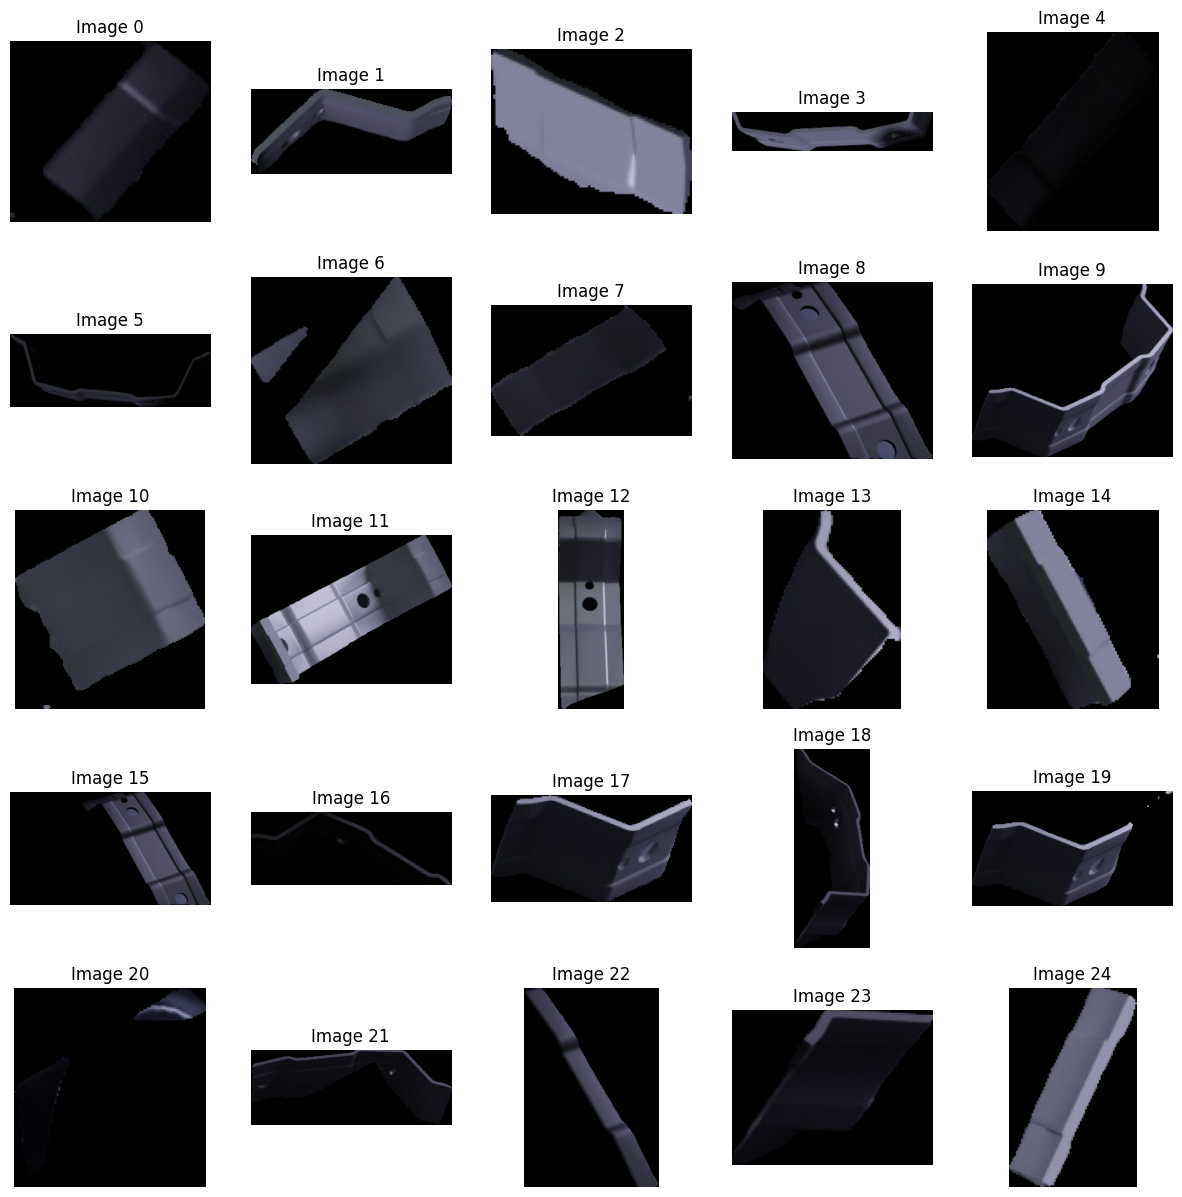

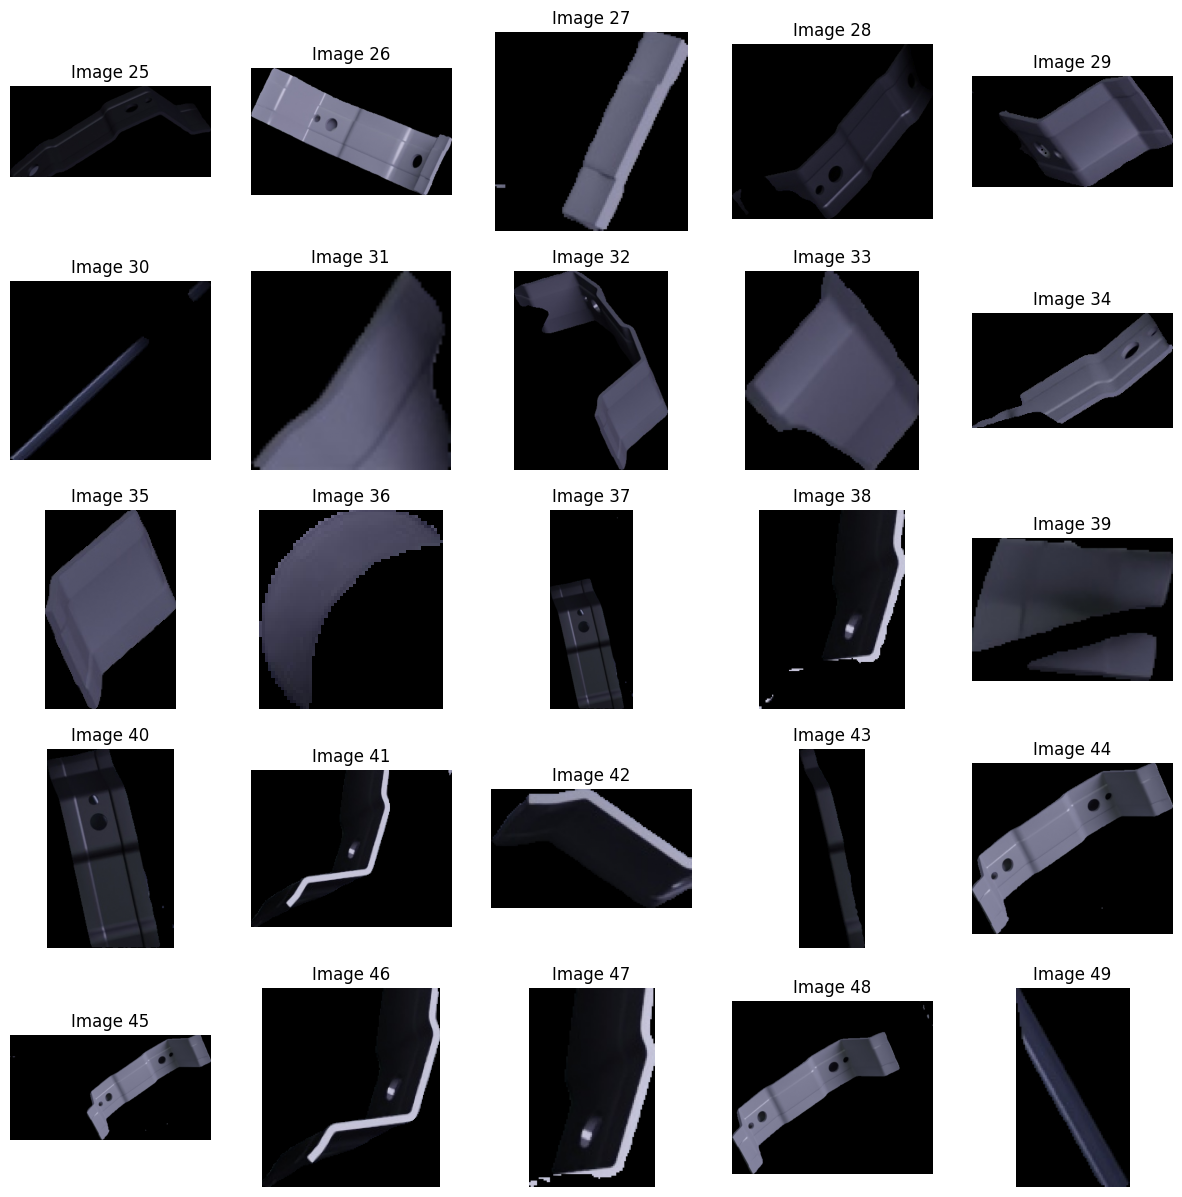

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display at a time
images_per_page = 25

# Define the number of rows and columns for the grid
rows = 5
cols = 5

# Iterate over the images in steps of images_per_page
for i in range(0, 50, images_per_page):
    # Create a new figure for each set of 25 images
    plt.figure(figsize=(15, 15))

    for j in range(images_per_page):
        # Calculate the current image index
        image_index = i + j

        # Check if the image_index is within the bounds of the list
        if image_index >= len(neg):
            break

        # Add a subplot for the current image
        plt.subplot(rows, cols, j + 1)
        plt.imshow(np.array(pos[image_index]["rgb"]))
        plt.title(f"Image {image_index}")
        plt.axis('off')

    # Display the figure containing 25 images
    plt.show()


## 1.2 Create positive and negative pairs
Positive pairs (positive proposal and template with most similar pose)

In [13]:
import torch

from src.model.constrastive_learning import ContrastiveLearningModel


# template_paths = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001/*.png"
# template_poses_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/template_poses.npy"
template_paths = "foundpose_analysis/hudiebanjin/templates/train_pbr/obj_000001_original/*.png"
template_poses_path = "foundpose_analysis/hudiebanjin/templates/train_pbr/obj_000001_original/poses.pkl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveLearningModel(device)
# model.load_state_dict(torch.load("contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"))

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
[2024-09-26 11:23:51,128] [INFO] dinov2: using MLP layer as FFN


In [14]:
len(pos)

4712

In [15]:
from src.model.constrastive_learning import prepare_dataset
train_dataset, val_dataset, test_dataset, train_negative_pairs, train_postive_pairs = prepare_dataset(
    template_paths, template_poses_path, pos[:2000], neg[:] # build only 1000 postive images
    )

  0%|          | 0/2000 [00:00<?, ?it/s][2024-09-26 11:23:56,091] [INFO] src.model.constrastive_learning_utils: Size of pos proposal: (3, 77, 85)
[2024-09-26 11:23:56,095] [INFO] src.model.constrastive_learning_utils: pos_pair['img1'].shape[-1], pos_pair['img2'].shape[-1]: 224, 224
[2024-09-26 11:23:56,101] [INFO] src.model.constrastive_learning_utils: Size of pos proposal: (3, 84, 199)
[2024-09-26 11:23:56,149] [INFO] src.model.constrastive_learning_utils: pos_pair['img1'].shape[-1], pos_pair['img2'].shape[-1]: 224, 224
[2024-09-26 11:23:56,152] [INFO] src.model.constrastive_learning_utils: Size of pos proposal: (3, 75, 91)
[2024-09-26 11:23:56,204] [INFO] src.model.constrastive_learning_utils: pos_pair['img1'].shape[-1], pos_pair['img2'].shape[-1]: 224, 224
  0%|          | 3/2000 [00:00<01:15, 26.39it/s][2024-09-26 11:23:56,205] [INFO] src.model.constrastive_learning_utils: Size of pos proposal: (3, 67, 350)
[2024-09-26 11:23:56,261] [INFO] src.model.constrastive_learning_utils: pos

In [16]:
len(pos)

4712

In [17]:
from torch.utils.data import DataLoader, Dataset


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=1)

[2024-09-26 11:29:54,992] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.21838779956427024].
[2024-09-26 11:29:54,997] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.06047930283224392].
[2024-09-26 11:29:55,003] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.8109803921568628].
[2024-09-26 11:29:55,008] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.6541176470588236].
[2024-09-26 11:29:55,012] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] f

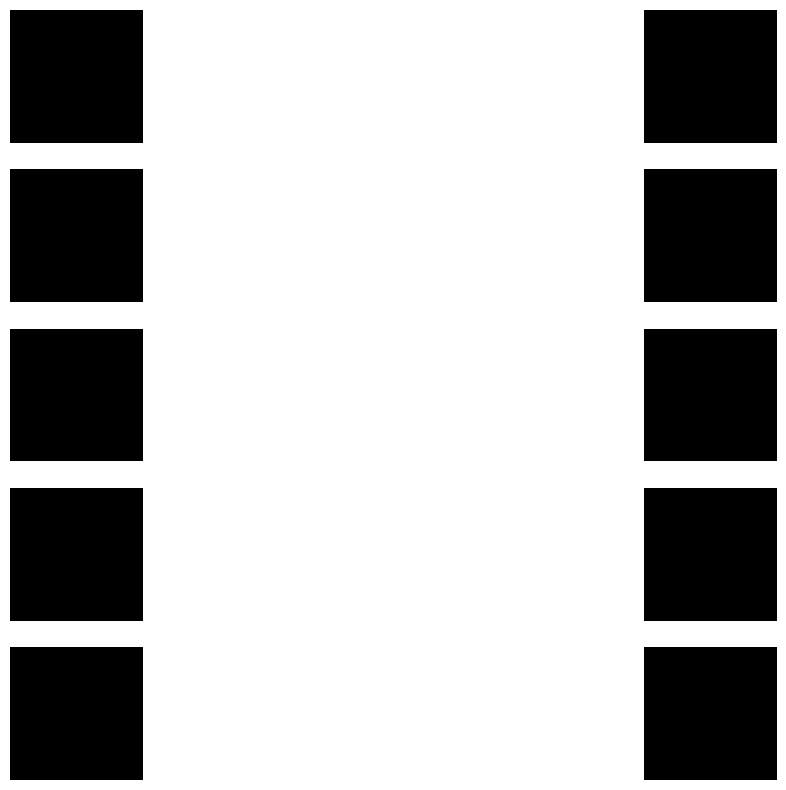

[2024-09-26 11:29:55,097] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.1171241830065357].
[2024-09-26 11:29:55,108] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.0].
[2024-09-26 11:29:55,114] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.5245315904139431].
[2024-09-26 11:29:55,121] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.9155555555555556].
[2024-09-26 11:29:55,125] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

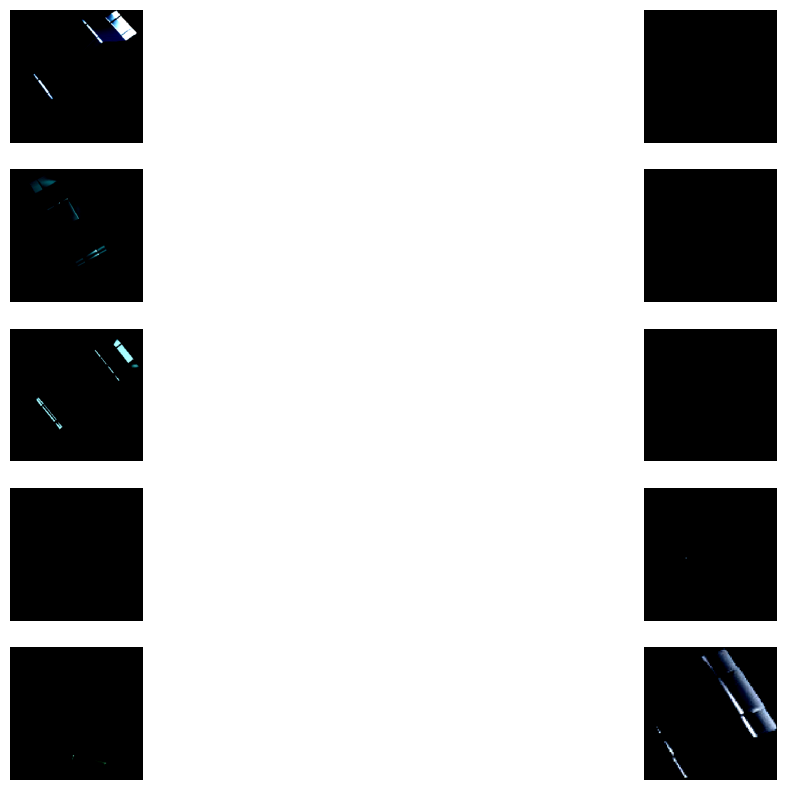

[2024-09-26 11:29:55,194] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.984226579520697].
[2024-09-26 11:29:55,200] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.1694117647058824].
[2024-09-26 11:29:55,205] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.5136383442265795].
[2024-09-26 11:29:55,209] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.8458387799564271].
[2024-09-26 11:29:55,348] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

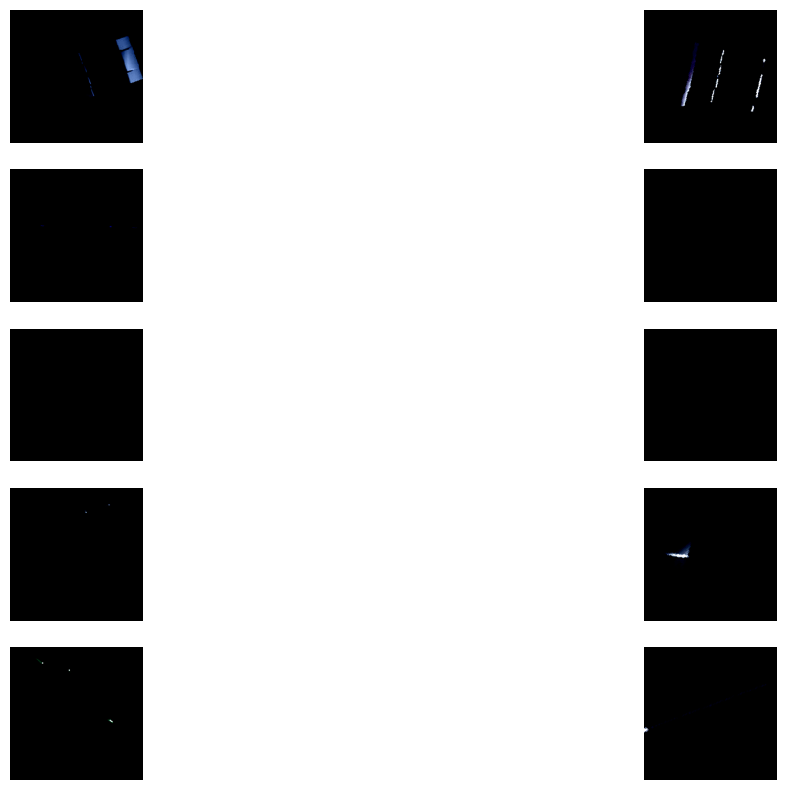

[2024-09-26 11:29:55,434] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.8447930283224399].
[2024-09-26 11:29:55,440] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.1410893246187361].
[2024-09-26 11:29:55,446] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.2216993464052286].
[2024-09-26 11:29:55,452] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.1933769063180828].
[2024-09-26 11:29:55,457] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

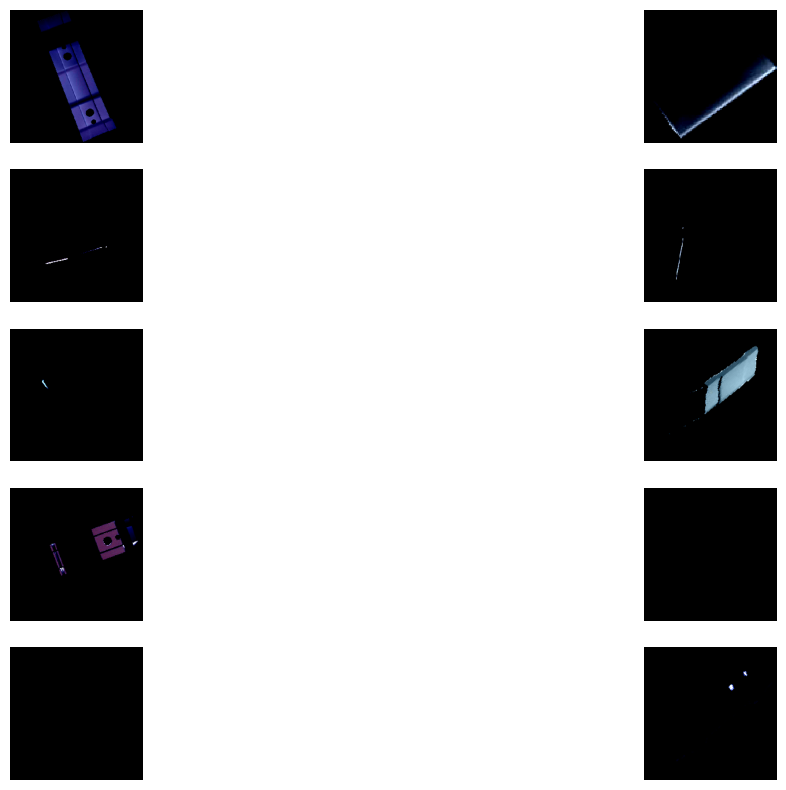

In [18]:
import matplotlib.pyplot as plt

# Define the number of pairs to show at a time
pairs_per_page = 5

# Iterate over the specified range of pairs, in steps of `pairs_per_page`
for i in range(20, 40, pairs_per_page):
    # Create a new figure for each set of 5 pairs
    plt.figure(figsize=(15, 10))  # Adjusted the figsize for multiple pairs

    for j in range(pairs_per_page):
        # Calculate the current pair index
        pair_index = i + j

        # Check if the pair_index is within the bounds of the list
        if pair_index >= len(train_postive_pairs):
            break

        pair = train_postive_pairs[pair_index]

        # First image in the pair (img2)
        plt.subplot(pairs_per_page, 2, 2*j + 1)
        plt.imshow(pair["img2"].permute(1, 2, 0))
        plt.axis('off')

        # Second image in the pair (img1)
        plt.subplot(pairs_per_page, 2, 2*j + 2)
        plt.imshow(pair["img1"].permute(1, 2, 0))
        plt.axis('off')

    # Display the figure containing 5 pairs
    plt.show()


[2024-09-26 11:29:55,556] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.9667973856209149].
[2024-09-26 11:29:55,563] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.8273638344226578].


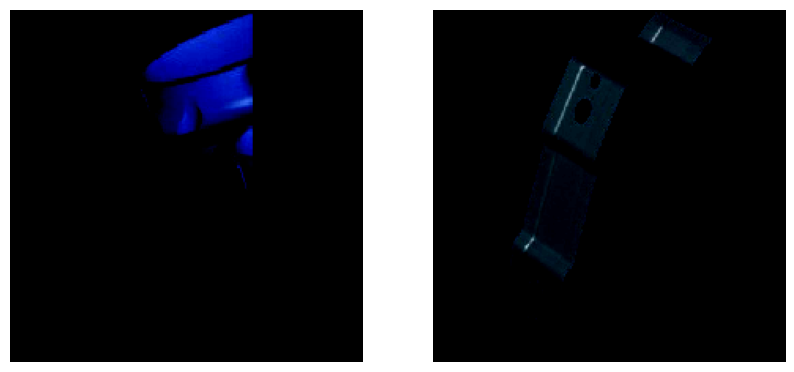

[2024-09-26 11:29:55,597] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.41010893246187374].
[2024-09-26 11:29:55,602] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.3437037037037034].


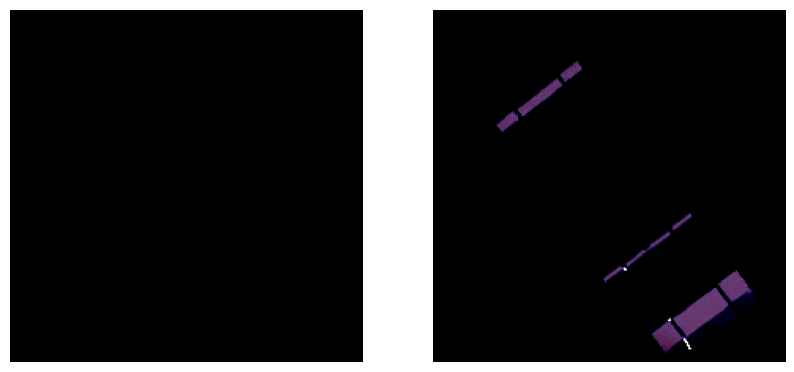

[2024-09-26 11:29:55,632] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.8099346405228758].
[2024-09-26 11:29:55,637] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.229281045751634].


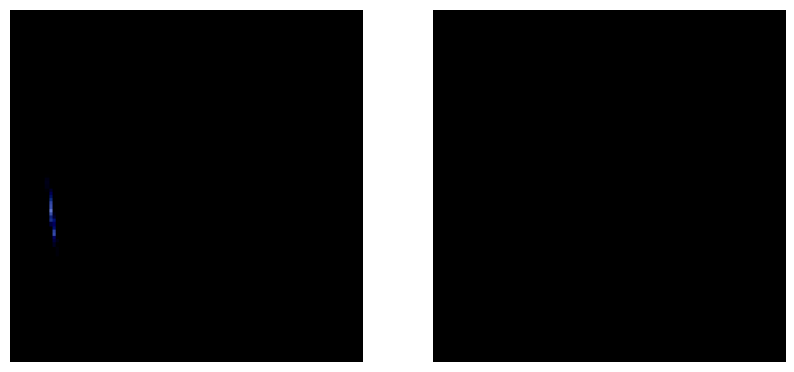

[2024-09-26 11:29:55,667] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.473289760348584].
[2024-09-26 11:29:55,673] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.7227886710239649].


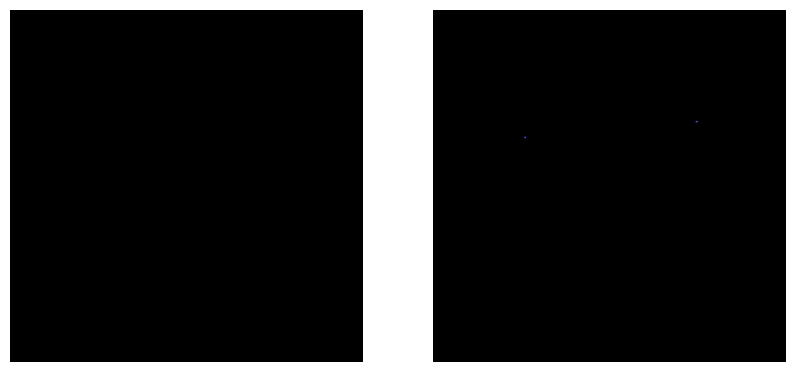

[2024-09-26 11:29:55,699] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.6879302832244008].
[2024-09-26 11:29:55,703] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.6465359477124182].


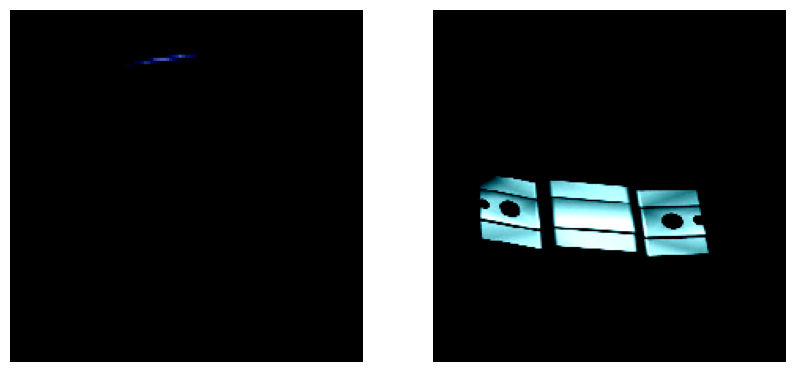

[2024-09-26 11:29:55,729] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.3752505446623094].
[2024-09-26 11:29:55,734] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.3850980392156862].


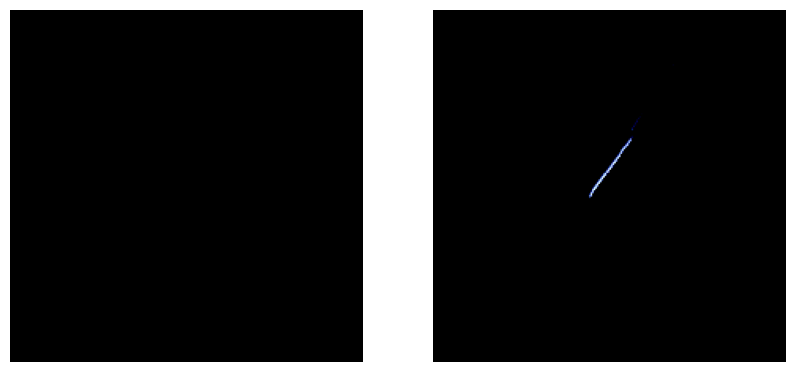

[2024-09-26 11:29:55,756] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.106230936819172].
[2024-09-26 11:29:55,762] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.02666666666666669].


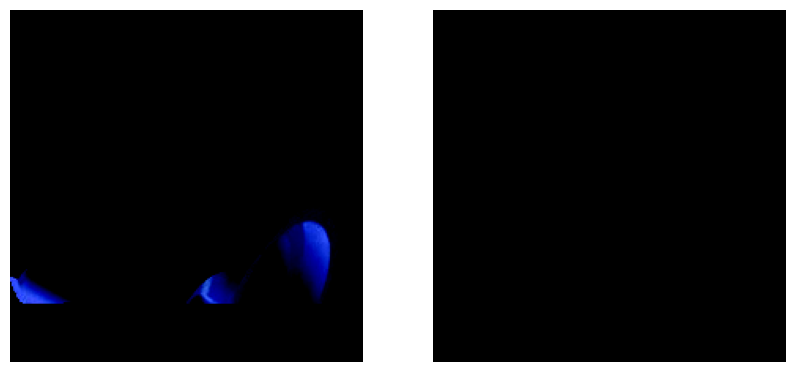

[2024-09-26 11:29:55,786] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.350239651416122].
[2024-09-26 11:29:55,791] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.5419607843137253].


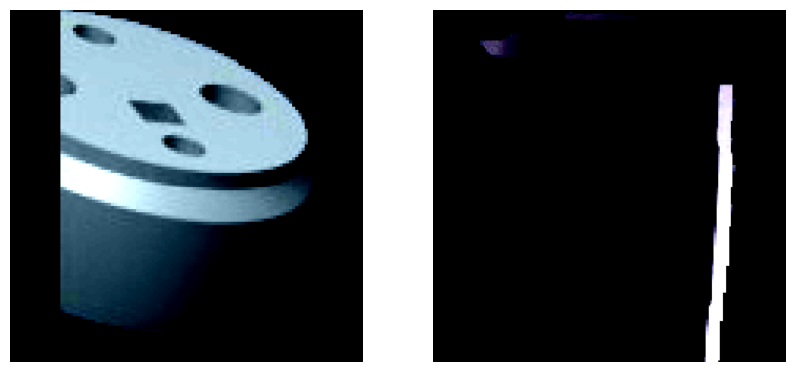

[2024-09-26 11:29:55,821] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.8033986928104573].
[2024-09-26 11:29:55,827] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.42753812636165583].


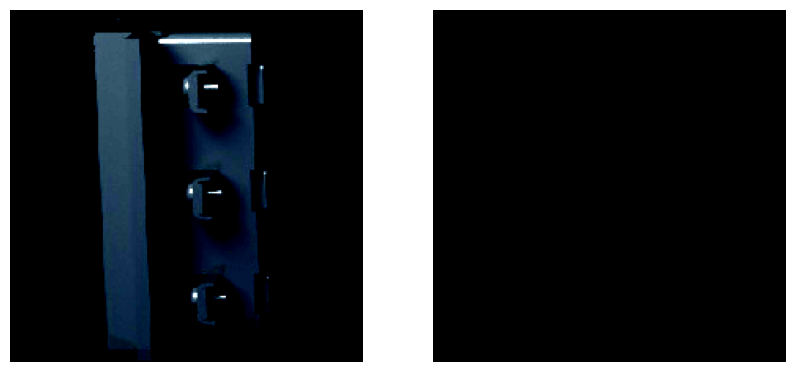

[2024-09-26 11:29:55,855] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.2815686274509803].
[2024-09-26 11:29:55,859] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.7750762527233116].


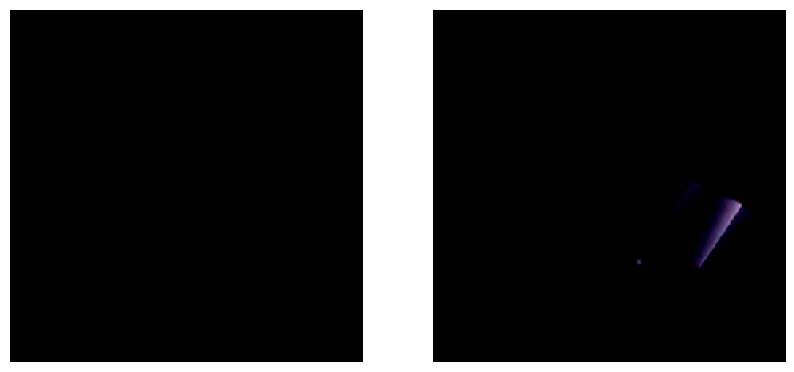

[2024-09-26 11:29:55,893] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.42649237472766865].
[2024-09-26 11:29:55,898] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.5833551198257079].


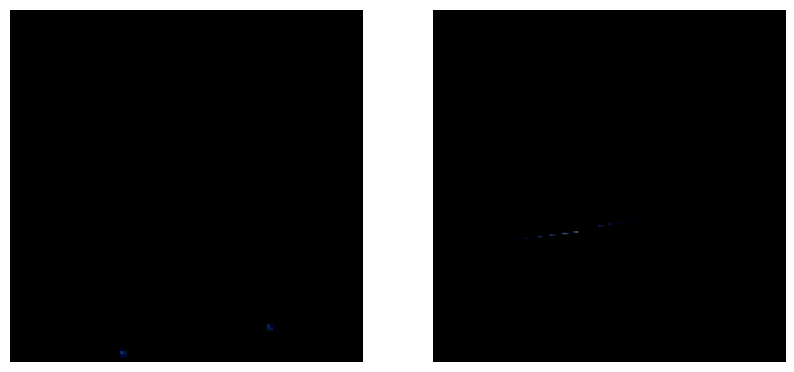

[2024-09-26 11:29:55,927] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.3861437908496732].
[2024-09-26 11:29:55,933] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.1933769063180828].


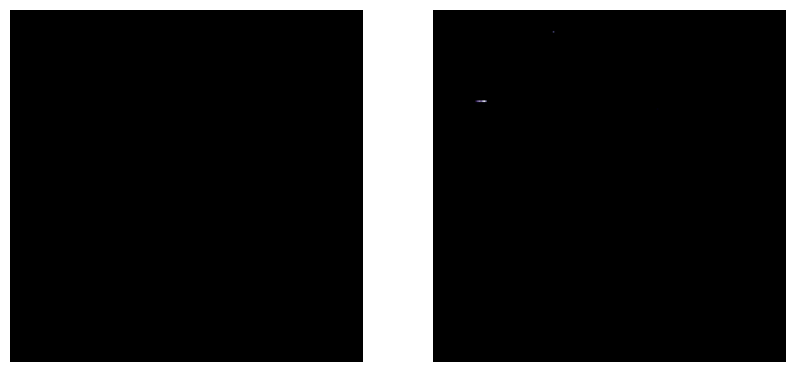

[2024-09-26 11:29:55,961] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.06047930283224392].
[2024-09-26 11:29:55,966] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.42753812636165583].


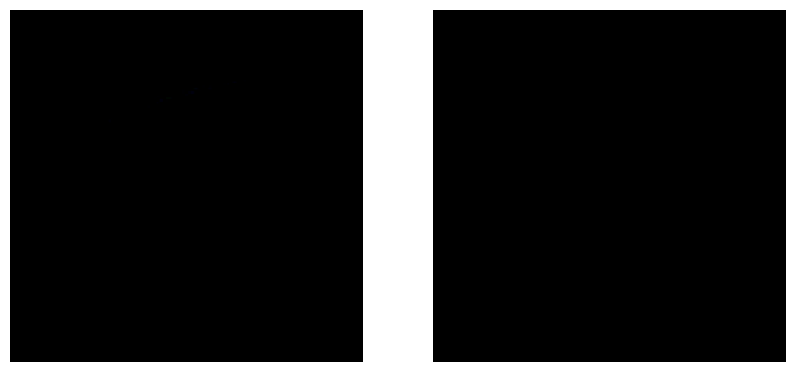

[2024-09-26 11:29:55,989] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.18248366013071893].
[2024-09-26 11:29:55,995] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.061525054466231084].


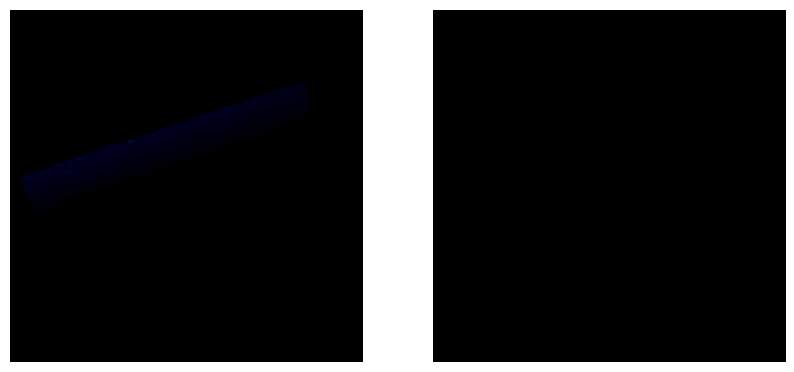

[2024-09-26 11:29:56,023] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.5778649237472768].
[2024-09-26 11:29:56,030] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.2630936819172112].


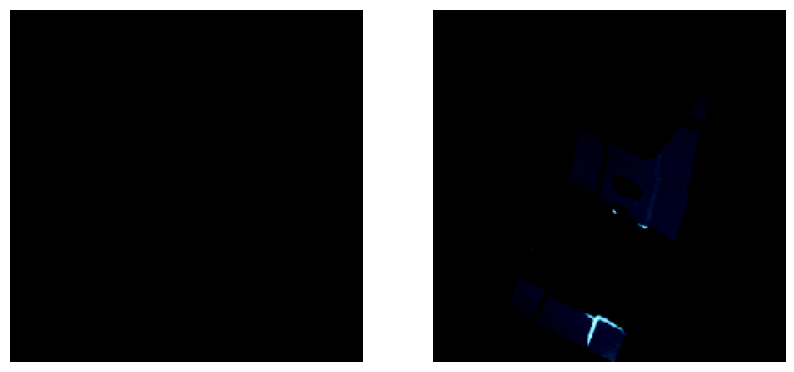

[2024-09-26 11:29:56,062] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.229281045751634].
[2024-09-26 11:29:56,067] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.13019607843137246].


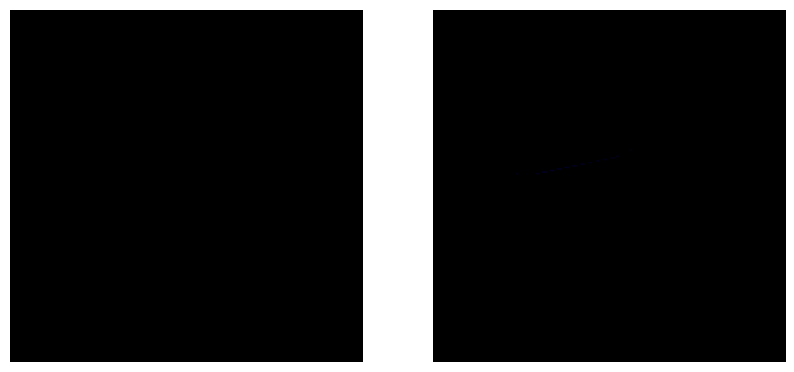

[2024-09-26 11:29:56,092] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.6232492997198877].
[2024-09-26 11:29:56,098] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.740217864923747].


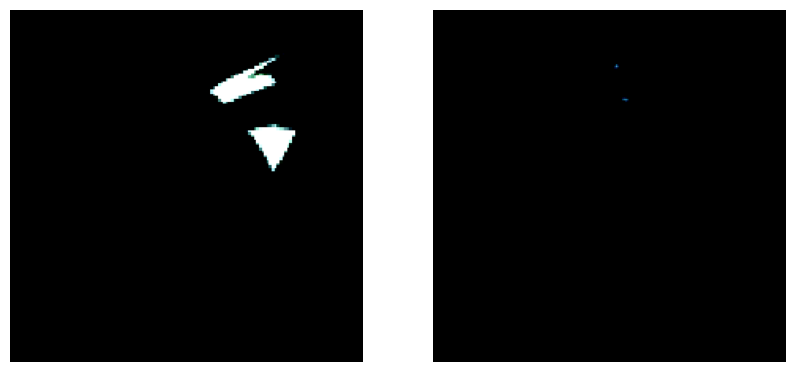

[2024-09-26 11:29:56,123] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.862222222222222].
[2024-09-26 11:29:56,129] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.3611328976034858].


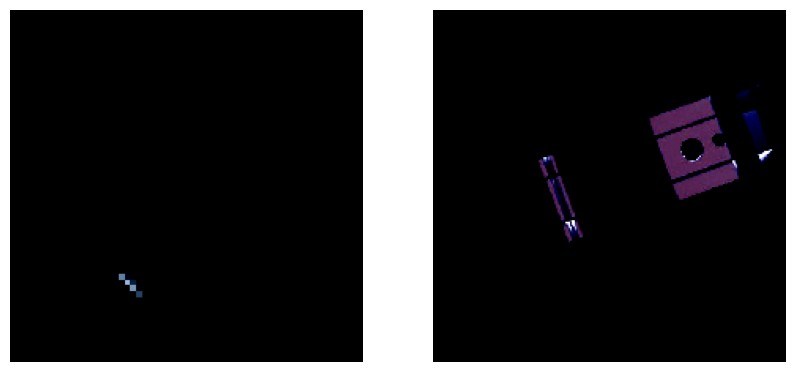

[2024-09-26 11:29:56,159] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.4384313725490199].
[2024-09-26 11:29:56,164] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.321917211328976].


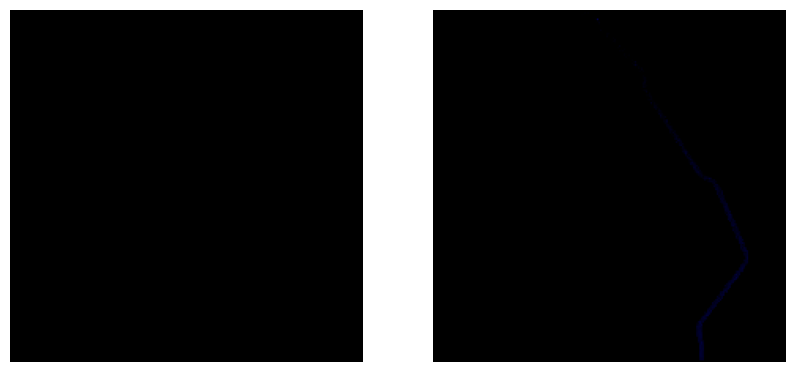

[2024-09-26 11:29:56,194] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.089847494553377].
[2024-09-26 11:29:56,200] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.5310675381263616].


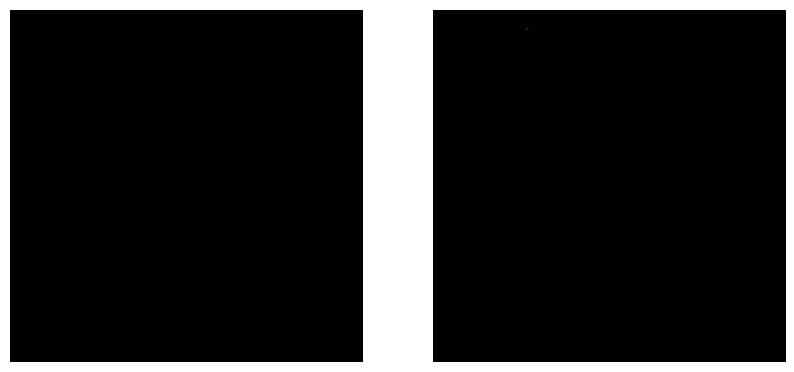

[2024-09-26 11:29:56,223] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.9504139433551199].
[2024-09-26 11:29:56,227] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.1345533769063176].


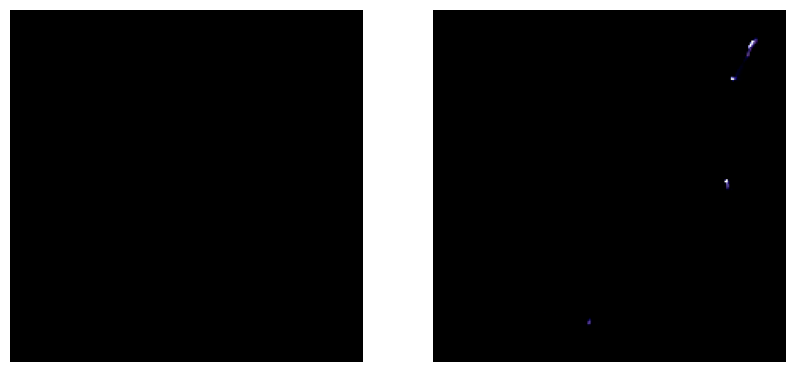

[2024-09-26 11:29:56,250] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.5146840958605664].
[2024-09-26 11:29:56,255] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.21734204793028306].


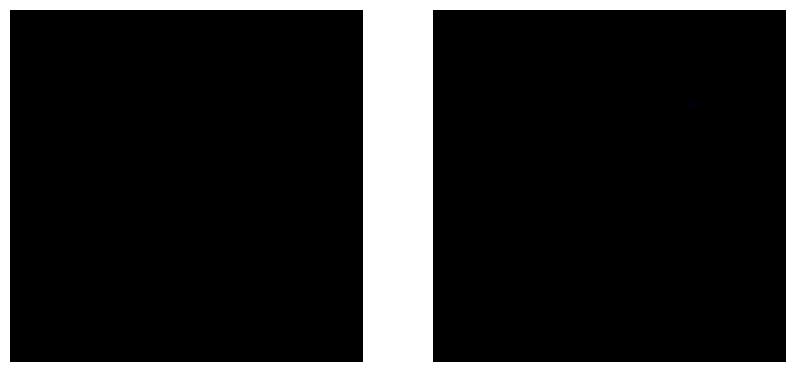

[2024-09-26 11:29:56,277] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.3977591036414563].
[2024-09-26 11:29:56,282] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.7750762527233116].


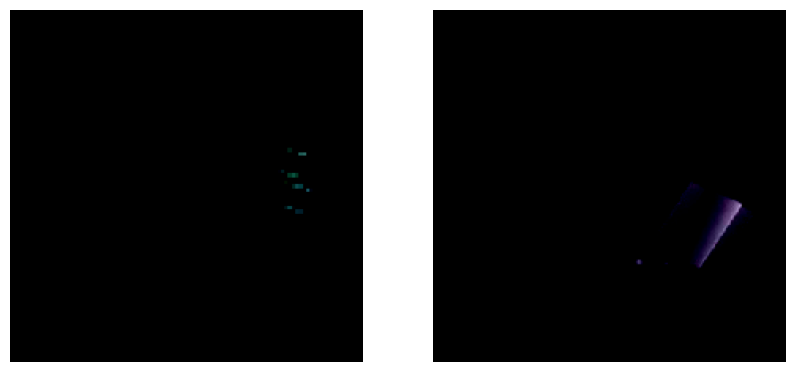

[2024-09-26 11:29:56,306] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.4035729847494554].
[2024-09-26 11:29:56,311] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.045518207282913].


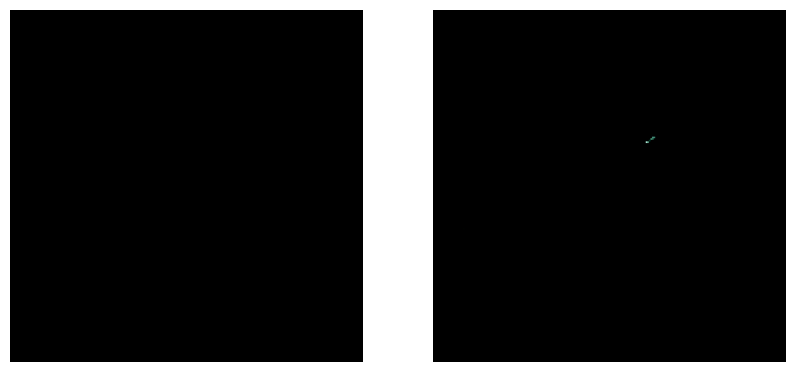

[2024-09-26 11:29:56,333] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.3393464052287581].
[2024-09-26 11:29:56,338] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.16505446623093661].


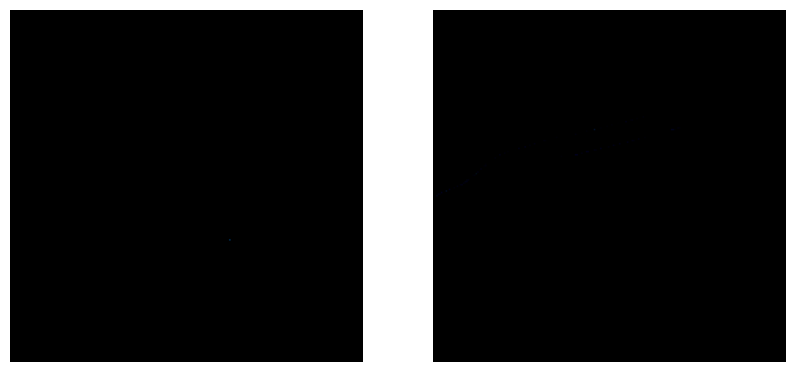

[2024-09-26 11:29:56,362] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.9852723311546842].
[2024-09-26 11:29:56,368] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.42753812636165583].


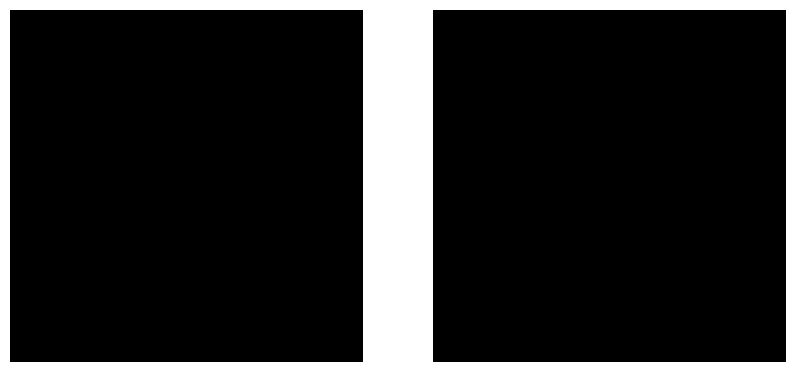

[2024-09-26 11:29:56,395] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.9319389978213508].
[2024-09-26 11:29:56,400] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.2630936819172112].


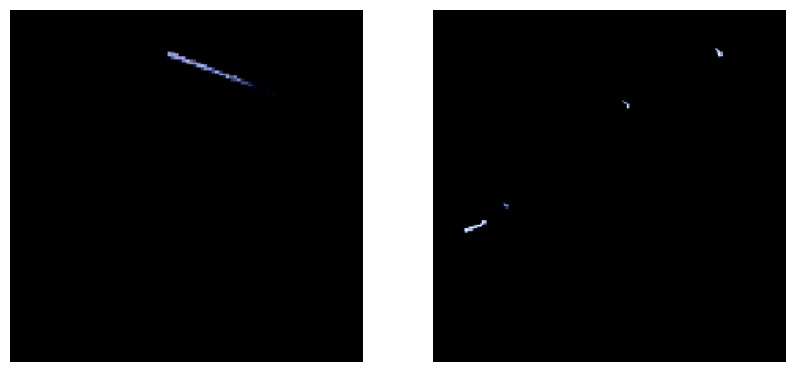

[2024-09-26 11:29:56,428] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.3926797385620917].
[2024-09-26 11:29:56,434] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.5532212885154062].


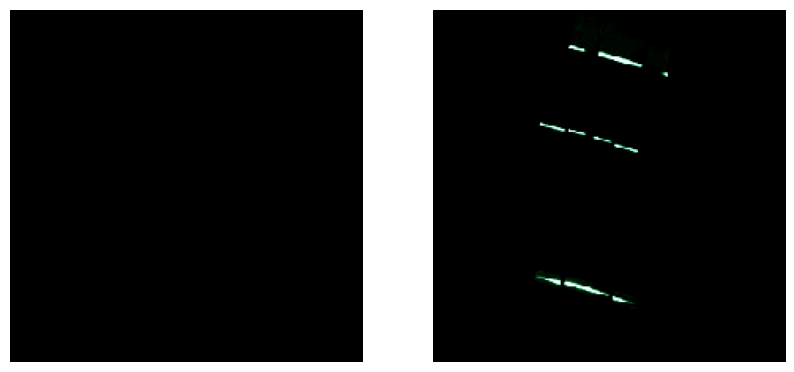

[2024-09-26 11:29:56,459] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.4787799564270149].
[2024-09-26 11:29:56,464] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.5136383442265795].


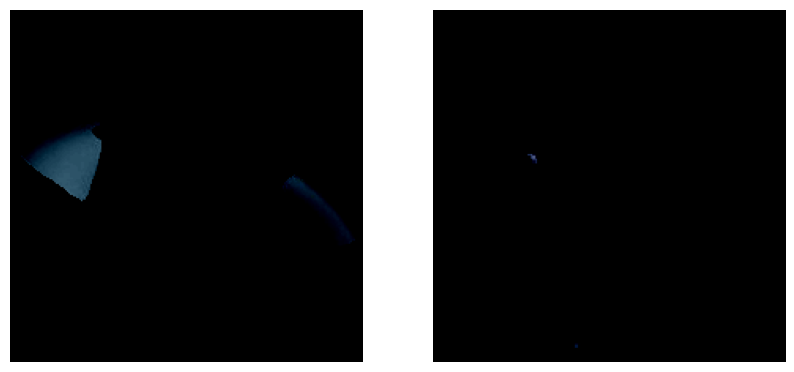

[2024-09-26 11:29:56,490] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.9504139433551199].
[2024-09-26 11:29:56,495] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.5136383442265795].


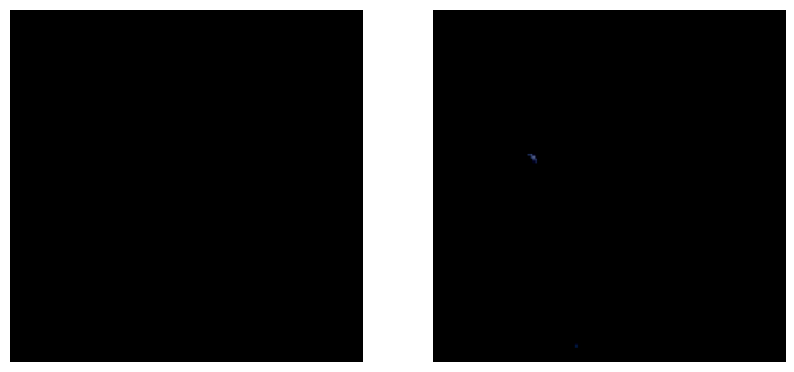

[2024-09-26 11:29:56,517] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-1.089847494553377].
[2024-09-26 11:29:56,524] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.11381263616557755].


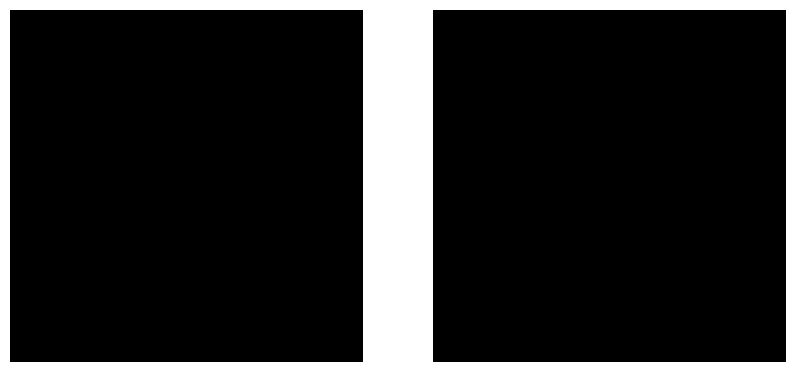

[2024-09-26 11:29:56,549] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.8284095860566449].
[2024-09-26 11:29:56,554] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.061525054466231084].


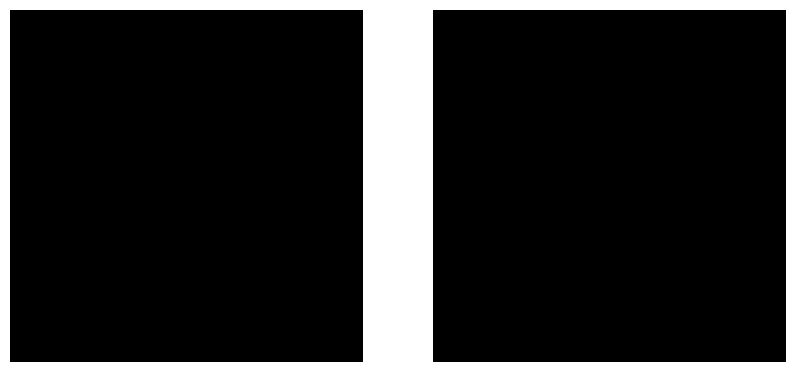

[2024-09-26 11:29:56,580] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.817927170868347].
[2024-09-26 11:29:56,748] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.629106753812636].


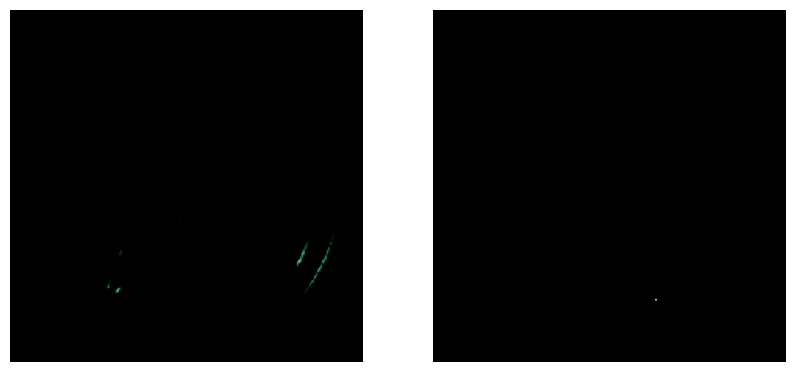

[2024-09-26 11:29:56,771] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.5126050420168068].
[2024-09-26 11:29:56,775] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.061525054466231084].


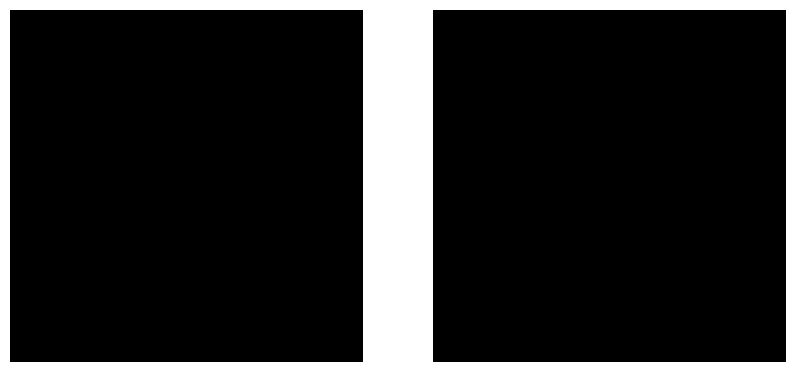

[2024-09-26 11:29:56,797] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.47982570806100233].
[2024-09-26 11:29:56,803] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.30553376906318086].


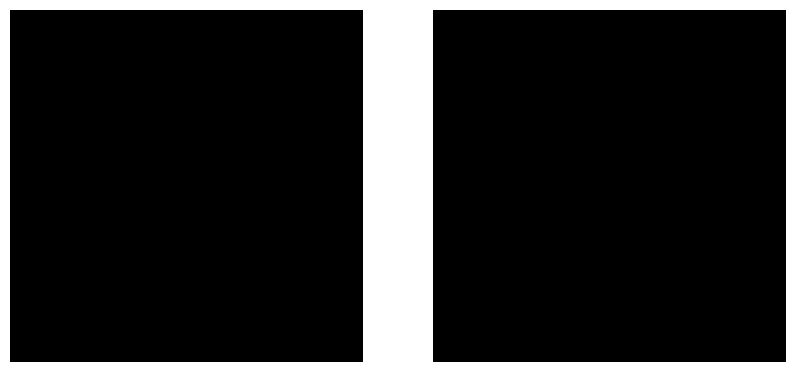

[2024-09-26 11:29:56,825] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.11381263616557755].
[2024-09-26 11:29:56,830] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.9493681917211328].


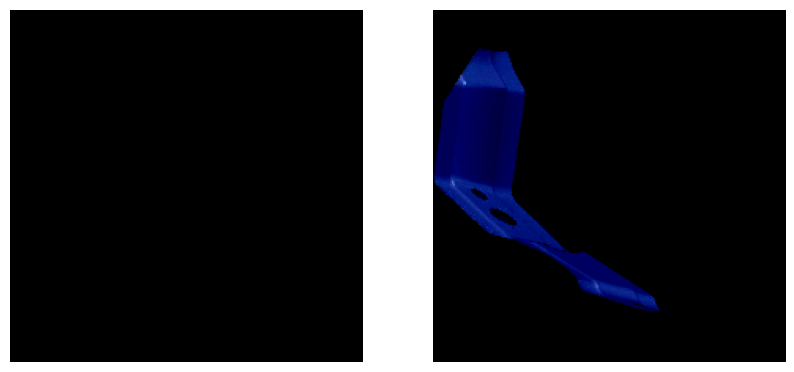

[2024-09-26 11:29:56,856] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.8382570806100216].
[2024-09-26 11:29:56,861] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.42753812636165583].


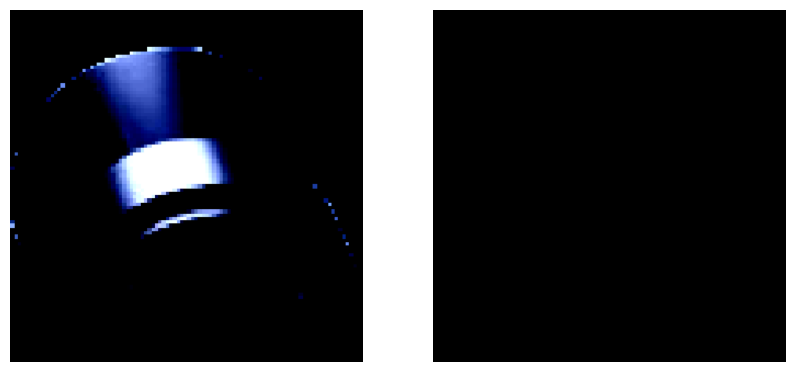

[2024-09-26 11:29:56,885] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.7750762527233116].
[2024-09-26 11:29:56,889] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..-0.11381263616557755].


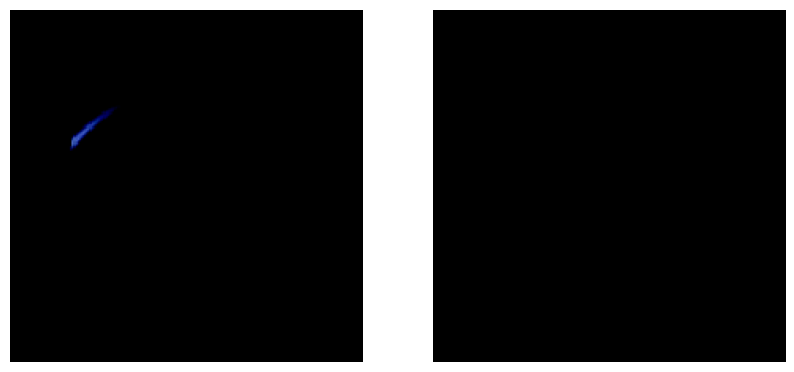

[2024-09-26 11:29:56,912] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.7750762527233116].
[2024-09-26 11:29:56,916] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.1933769063180828].


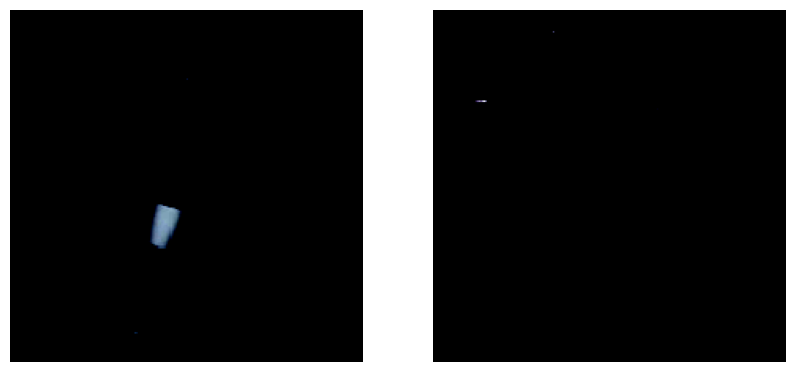

[2024-09-26 11:29:56,939] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..0.757647058823529].
[2024-09-26 11:29:56,944] [WARNING] matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..1.245664488017429].


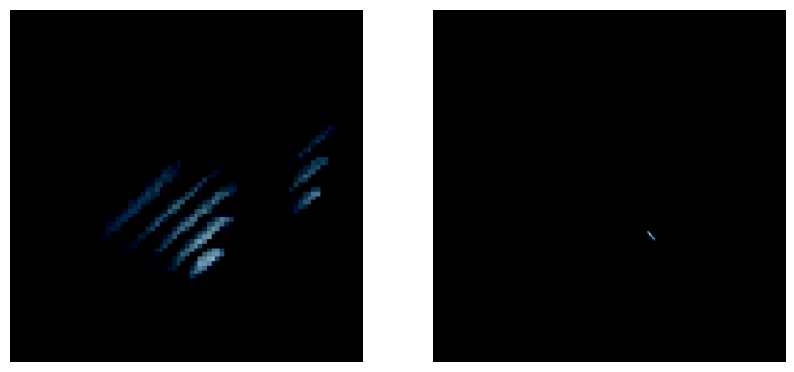

In [19]:
import matplotlib.pyplot as plt
for pair in train_negative_pairs[:40]:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pair["img1"].permute(1,2,0))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pair["img2"].permute(1,2,0))
    plt.axis('off')

    plt.show()

In [22]:
len(val_dataset)

1895

In [23]:
from src.model.constrastive_learning import train_contrastive_loss, train_contrastive_loss_hard_case_mining

train_contrastive_loss(device, model, train_loader, val_loader, num_epochs=25)
# train_contrastive_loss(device, model, train_dataset, val_dataset, test_dataset, num_epochs=25) # this time train_pbr

Training:   0%|          | 0/25 [00:00<?, ?it/s]/home/cuong.van-dam/miniconda3/envs/cnos/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/cuong.van-dam/miniconda3/envs/cnos/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
[

best_val_loss:  0.6760718341963955
saving best model at epoch:  0


Training:  12%|█▏        | 3/25 [55:15<6:38:46, 1087.58s/it][2024-09-26 12:50:37,608] [INFO] src.model.constrastive_learning: Epoch 4/25 loss: 0.71455
[2024-09-26 12:51:32,492] [INFO] src.model.constrastive_learning: Epoch 4/25 Validation Loss: 0.45592


best_val_loss:  0.455924257076589
saving best model at epoch:  3


Training:  24%|██▍       | 6/25 [1:48:19<5:36:44, 1063.40s/it][2024-09-26 13:43:40,661] [INFO] src.model.constrastive_learning: Epoch 7/25 loss: 0.63236
[2024-09-26 13:44:35,554] [INFO] src.model.constrastive_learning: Epoch 7/25 Validation Loss: 0.44909


best_val_loss:  0.4490901094601973
saving best model at epoch:  6


Training:  36%|███▌      | 9/25 [2:43:48<4:52:27, 1096.73s/it][2024-09-26 14:39:08,860] [INFO] src.model.constrastive_learning: Epoch 10/25 loss: 0.59478
[2024-09-26 14:40:03,575] [INFO] src.model.constrastive_learning: Epoch 10/25 Validation Loss: 0.39268


best_val_loss:  0.39267923074129985
saving best model at epoch:  9


Training:  48%|████▊     | 12/25 [3:36:47<3:51:20, 1067.74s/it][2024-09-26 15:32:06,843] [INFO] src.model.constrastive_learning: Epoch 13/25 loss: 0.57968
[2024-09-26 15:33:01,525] [INFO] src.model.constrastive_learning: Epoch 13/25 Validation Loss: 0.37818


best_val_loss:  0.37818068192332577
saving best model at epoch:  12


Training:  60%|██████    | 15/25 [4:29:43<2:56:17, 1057.71s/it][2024-09-26 16:25:03,206] [INFO] src.model.constrastive_learning: Epoch 16/25 loss: 0.54561
[2024-09-26 16:25:58,657] [INFO] src.model.constrastive_learning: Epoch 16/25 Validation Loss: 0.63481
Training:  64%|██████▍   | 16/25 [5:04:50<2:51:28, 1143.16s/it]


KeyboardInterrupt: 

# 3. Test

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import glob
import torchvision.transforms as T
import torch

from src.model.constrastive_learning import ContrastiveLearningModel
from src.model.constrastive_learning_utils import resize_and_pad_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reverse_normalization(normalized_output):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    original_image = normalized_output * std + mean
    return np.clip(original_image, 0, 1)

model = ContrastiveLearningModel(device)
model.load_state_dict(torch.load("contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"))
model = model.to(device)

transform = T.Compose(
        [
            # transforms.Lambda(lambda x: x / 255.0),  # Ensures the scaling by 255.0
            # T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
crop_path = "cnos_analysis/crop_proposals/crop1.png"
crop_rgb = np.transpose(np.array(Image.open(crop_path).convert("RGB"))[:,:,:3]/255.0, (2,0,1)) # (124, 157, 3)
img2_temp = transform(resize_and_pad_image(crop_rgb, target_max=224)).unsqueeze(0).float().to(device)
count_true = 0
count_false = 0
false_indices = []

# for i, test_data in enumerate(tqdm(test_dataset)):
    # if i < 200:
    #     continue

labels = torch.tensor([test_dataset[i][2] for i in range(len(test_dataset))]).to(device).to(torch.float32)
img1 = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(device).to(torch.float32)
img2 = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))]).to(device).to(torch.float32)

        # # _, predicted = torch.max(outputs_test.cpu(), 1)
        # if predicted==label:
        #     count_true +=1
        # else:
        #     count_false +=1
        #     false_indices.append(i)

        # print(f"Prediction: {predicted} - GT : {label}")
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # # plt.imshow(np.array(reverse_normalization(img1.squeeze().cpu()).permute(1,2,0)))
        # plt.imshow(np.array((img1.squeeze().cpu()).permute(1,2,0)))
        # plt.axis('off')

        # plt.subplot(1, 2, 2)
        # plt.imshow(np.array((img2.squeeze().cpu()).permute(1,2,0)))
        # plt.axis('off')

        # plt.show()

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
[2024-09-15 20:10:02,509] [INFO] dinov2: using MLP layer as FFN


NameError: name 'test_dataset' is not defined

: 

In [26]:
torch.cuda.empty_cache()
del model

In [27]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    
    output1, output2 = model(img1, img2)
    

NameError: name 'model' is not defined

In [32]:
img1.shape

torch.Size([106, 3, 224, 224])

In [29]:
euclidean_distance = nn.functional.pairwise_distance(output1, output2)
euclidean_distance

tensor([0.1085, 0.1120, 0.5385, 0.0833, 0.4430, 0.0936, 0.2402, 0.0995, 0.1053,
        0.1207, 0.1109, 0.1384, 0.1025, 0.1224, 0.1641, 0.0835, 0.0974, 0.5218,
        2.6321, 1.3321, 0.2011, 0.0990, 0.1550, 0.2576, 0.1980, 0.1708, 0.1113,
        0.5935, 0.1830, 0.1184, 0.1601, 0.1137, 0.2439, 0.2496, 0.4019, 0.3217,
        0.0880, 0.2650, 1.0322, 0.4573, 0.6022, 0.4413, 0.2153, 0.1978, 0.0958,
        0.1697, 0.0852, 0.1220, 0.2026, 0.1335, 0.1467, 0.3417, 0.0997, 2.7049,
        0.1111, 0.1694, 2.6606, 2.6463, 4.5063, 1.4166, 0.0929, 2.6888, 5.0151,
        1.2368, 0.1078, 3.4303, 2.2541, 0.9189, 2.8231, 3.2603, 0.5690, 2.0508,
        1.4355, 2.7304, 2.4170, 5.7329, 1.3703, 0.2520, 6.3086, 2.5689, 2.1882,
        2.1293, 1.6889, 0.5110, 4.1631, 2.8875, 2.4324, 2.0943, 0.3887, 2.8543,
        2.1684, 2.8268, 2.6728, 2.7903, 0.8073, 2.8617, 4.7174, 2.5247, 2.4582,
        1.4498, 1.8600, 2.6151, 1.1359, 2.1268, 2.6896, 1.4226],
       device='cuda:0')

In [30]:
obj_num = torch.sum(torch.where(euclidean_distance<1,1,0))
non_obj_num = torch.sum(torch.where(euclidean_distance<1,0,1))
obj_num

tensor(60, device='cuda:0')

In [31]:
non_obj_num

tensor(46, device='cuda:0')

In [36]:
len(test_dataset)

200

In [38]:
x = predicted.squeeze()
y = labels.cpu()
matches = (x==y)
num_matches = torch.sum(matches).item()
num_matches

1619

In [40]:
mismatch_indices = torch.nonzero(x != y, as_tuple=False).squeeze()
mismatch_indices

tensor([  76,   88,  101,  353,  356,  407,  422,  427, 1255, 1444])

In [27]:
labels.shape

torch.Size([1629])

In [17]:
labels.shape

torch.Size([1629])

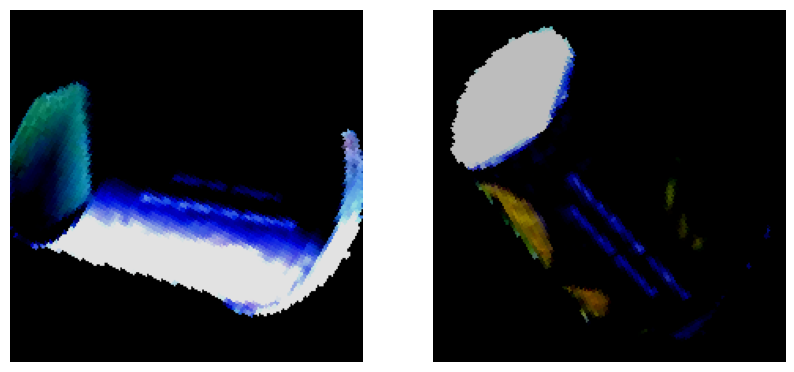

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plt.imshow(np.array(reverse_normalization(img1.squeeze().cpu()).permute(1,2,0)))
plt.imshow(np.array((train_dataset[76][0].squeeze().cpu()).permute(1,2,0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.array((train_dataset[76][1].squeeze().cpu()).permute(1,2,0)))
plt.axis('off')

plt.show()

In [ ]:
count_false

2

In [ ]:
false_indices

[358, 444]

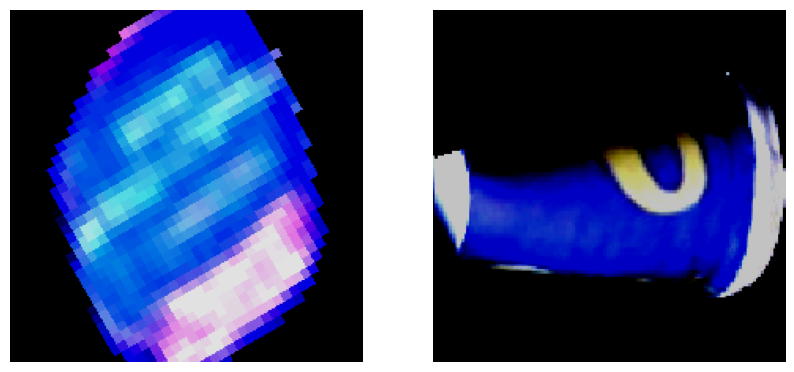

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plt.imshow(np.array(reverse_normalization(img1.squeeze().cpu()).permute(1,2,0)))
plt.imshow(np.array((test_dataset[311][0].squeeze().cpu()).permute(1,2,0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.array((test_dataset[311][1].squeeze().cpu()).permute(1,2,0)))
plt.axis('off')

plt.show()

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import glob

from src.model.constrastive_learning import ContrastiveModel, resize_and_pad_image


transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

model = ContrastiveModel(device)
model.load_state_dict(torch.load("contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"))
model = model.to(device)
# criterion = ContrastiveLoss()

template_paths = glob.glob("foundpose_analysis/icbin/templates/train_pbr_images_templates/obj_000001_original/*.png")
templates = [np.array(Image.open(template_path).convert("RGB"))[:,:,:3]/255.0 for template_path in template_paths]

proposal = np.array(neg[5]["rgb"])
img1 = resize_and_pad_image(transform(proposal), target_max=224).unsqueeze(0).float().to(device)

for temp in enumerate(templates):
    img2 = resize_and_pad_image(transform(temp), target_max=224).unsqueeze(0).float().to(device)

    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        
        outputs_test = model(img1, img2)
        _, predicted = torch.max(outputs_test, 1)

        
        print(f"Dissimilarity score: {predicted}")
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(proposal)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(temp)
        plt.axis('off')

        plt.show()
        # neg_class = criterion(output1_test, output2_test, 0)
        # pos_class = criterion(output1_test, output2_test, 1)
        
        # print(f"neg_class : {neg_class}, pos_class: {pos_class}")
        # if neg_class>0.5 and pos_class>0.5:
        #     print(" Not able to identify - wrong case")
        # if neg_class<0.5 and pos_class<0.5:
        #     print(" Not able to identify - wrong case")
        # elif neg_class>0.5:
        #     print("proposal is negative")
        # elif pos_class>0.5:
        #     print("proposal is positive")

# 7. Nhap

In [ ]:
import torch.nn as nn
class ContrastiveLoss2(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__() 
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate Euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        # Calculate loss
        loss_contrastive = torch.mean(
            label * torch.pow(euclidean_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        ) # without means it return size (B) as score for each pair in img1 and img2

        return loss_contrastive

loss = ContrastiveLoss2()

import torch

img1 = torch.randn(4,1024)
img2 = torch.randn(4,1024)
label = torch.tensor([1,0,0,0])

l = loss(img1, img2, label)

In [ ]:
l

tensor(525.5749)

In [ ]:
# def pose_similarity(given_pose, poses):
#     R_given, t_given = np.array(given_pose[:3, :3]), np.array(given_pose[:3, 3])
#     similarities = []

#     for idx, pose in enumerate(poses):
#         R, t = np.array(pose[:3, :3]), np.array(pose[:3, 3])
        
#         # Calculate Euclidean distance for translation
#         translation_dist = np.linalg.norm(t_given - t)
        
#         # Calculate Frobenius norm for rotation
#         rotation_dist = np.linalg.norm(R_given - R, ord='fro')

#         # Total similarity measure (you can adjust the weights if needed)
#         total_dist = translation_dist + rotation_dist
#         similarities.append((total_dist, idx))

#     # Sort by similarity (lower distance means more similar)
#     similarities.sort()

#     return similarities

# given_pose = pos_proposals[0][0]["pose"]
# poses = templates["poses"]
# similarity_scores = pose_similarity(given_pose, poses)
# top_5_similar = similarity_scores[:5]

In [ ]:
# from scipy.spatial.distance import cdist
# from scipy.spatial.transform import Rotation
# import matplotlib.pyplot as plt

# def compute_inplane(rot_query_openCV, rot_template_openCV):
#     delta = rot_template_openCV.dot(rot_query_openCV.T)
#     inp = extract_inplane_from_pose(delta)
#     # double check to make sure that reconved rotation is correct
#     R_inp = convert_inplane_to_rotation(inp)
#     recovered_R1 = R_inp.dot(rot_template_openCV)
#     err = geodesic_numpy(recovered_R1, rot_query_openCV)
#     if err >= 15:
#         print("WARINING, error of recovered pose is >=15, err=", err)
#     return inp

# def opencv2opengl(cam_matrix_world):
#     transform = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#     if len(cam_matrix_world.shape) == 2:
#         return np.matmul(transform, cam_matrix_world)
#     else:
#         transform = np.tile(transform, (cam_matrix_world.shape[0], 1, 1))
#         return np.matmul(transform, cam_matrix_world)

# def extract_inplane_from_pose(pose):
#     inp = Rotation.from_matrix(pose).as_euler("zyx", degrees=True)[0]
#     return inp

# def convert_inplane_to_rotation(inplane):
#     R_inp = Rotation.from_euler("z", -inplane, degrees=True).as_matrix()
#     return R_inp

# def geodesic_numpy(R1, R2):
#     theta = (np.trace(R2.dot(R1.T)) - 1) / 2
#     theta = np.clip(theta, -1, 1)
#     return np.degrees(np.arccos(theta))

# def extract_positive_pairs(all_pos_proposals)
#     pos_pairs = list()
#     for proposals_id in range(len(all_pos_proposals)):
#         obj_query_pose = all_pos_proposals[proposals_id]["pose"][None]
#         obj_template_poses = templates["poses"]

#         return_inplane = True

#         obj_query_openGL_pose = opencv2opengl(obj_query_pose)
#         obj_query_openGL_location = obj_query_openGL_pose[:, 2, :3]  # Mx3 # (translation components) -  It assumes that the 3D location is found in the third column of the pose matrices.
#         obj_template_openGL_poses = opencv2opengl(obj_template_poses)
#         obj_template_openGL_locations = obj_template_openGL_poses[:, 2, :3]  # Nx3 # (translation components)

#         # find the nearest template
#         # It computes the pairwise distances between each query pose location and each template pose location using cdist.
#         distances = cdist(obj_query_openGL_location, obj_template_openGL_locations)
#         best_index_in_pose_distribution = np.argmin(distances, axis=-1)  # M
#         if return_inplane:
#             nearest_poses = obj_template_poses[best_index_in_pose_distribution]
#             inplanes = np.zeros(len(obj_query_pose))
#             for idx in range(len(obj_query_pose)):
#                 rot_query_openCV = obj_query_pose[idx, :3, :3]
#                 rot_template_openCV = nearest_poses[idx, :3, :3]
#                 inplanes[idx] = compute_inplane(rot_query_openCV, rot_template_openCV)
#         #     return self.avail_index[best_index_in_pose_distribution], inplanes #  self.avail_index is just the index from 0 to 42

#         pos_pair = {
#             "img1" : templates["rgb"][best_index_in_pose_distribution[0]],
#             "img2" : all_pos_proposals[proposals_id]["rgb"],
#             "label" : 1
#         }
#         pos_pairs.append(pos_pair)
#         # plt.figure(figsize=(10, 5))
#         # plt.subplot(1, 2, 1)
#         # plt.imshow(templates["rgb"][best_index_in_pose_distribution[0]])
#         # plt.axis('off')

#         # plt.subplot(1, 2, 2)
#         # plt.imshow(all_pos_proposals[proposals_id]["rgb"])
#         # plt.axis('off')

#         # plt.show()
#     return pos_pairs